# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare
import model

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Acquire


In [2]:
#acquire data and do rudimentary exploration
df = acquire.get_telco_data()
df.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [3]:
working = df.copy(deep=True)

# Prepare

### View data and verify suggested actions from acquire

In [4]:
# view dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
df.describe()

,internet_service_type_id,payment_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.872923,2.315633,1.690473,0.162147,32.371149,64.761692
std,0.737796,1.148907,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,2.000000,3.000000,2.000000,0.000000,55.000000,89.850000
max,3.000000,4.000000,3.000000,1.000000,72.000000,118.750000


Takeaways
* id columns serve no purpose. *drop  
* tenure appears to be in months, monthly charges in dollars  
* where is total_charges? checked --> type == object. *must convert  

In [6]:
# convert series dtype to numeric after editing, and describe --> *make perm in prepare module
pd.to_numeric(df.total_charges.str.strip()).describe() 

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: total_charges, dtype: float64

In [7]:
# dataframe containing categorical columns
cat_col = df.select_dtypes(exclude='number').drop(columns=['customer_id', 'total_charges'])

#iterate through categorical columns
for col in cat_col:
   print(col)
   tempdf = pd.DataFrame()
   tempdf['Counts'] = df[col].value_counts()
   tempdf['Propotions']= (df[col].value_counts(normalize=True))
   print(tempdf)
   print(('------'))


gender
        Counts  Propotions
Male      3555    0.504756
Female    3488    0.495244
------
partner
     Counts  Propotions
No     3641    0.516967
Yes    3402    0.483033
------
dependents
     Counts  Propotions
No     4933    0.700412
Yes    2110    0.299588
------
phone_service
     Counts  Propotions
Yes    6361    0.903166
No      682    0.096834
------
multiple_lines
                  Counts  Propotions
No                  3390    0.481329
Yes                 2971    0.421837
No phone service     682    0.096834
------
online_security
                     Counts  Propotions
No                     3498    0.496663
Yes                    2019    0.286668
No internet service    1526    0.216669
------
online_backup
                     Counts  Propotions
No                     3088    0.438450
Yes                    2429    0.344881
No internet service    1526    0.216669
------
device_protection
                     Counts  Propotions
No                     3095    0.439443
Yes

In [8]:
# reassign with prep_telco output to prepare for data split
working = prepare.prep_telco(working)
working

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,1,0,0,0,1,0,1,0,0
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,1,0,0,0,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,1,0,0,0,1,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,...,0,0,0,0,0,1,0,0,0,0
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,1
7040,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,1,0,0,0,0,0,0,0,0
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,...,0,0,0,1,0,1,0,0,0,1


In [9]:
# assign total_charges value to zero for customers with zero tenure ---> these are new customers
working.total_charges.fillna(0.00, inplace=True)

In [10]:
working.churn

0        No
1        No
2       Yes
3       Yes
4       Yes
       ... 
7038     No
7039    Yes
7040     No
7041     No
7042     No
Name: churn, Length: 7043, dtype: object

In [11]:
# split the data with target *churn*
train, validate, test = prepare.split_data(working, 'churn')

Prepared df: (7043, 47)

Train: (4225, 47)
Validate: (1409, 47)
Test: (1409, 47)


## Takeaways
* Safe to get rid of columns used for SQL join.   
* Customer id has no bearing on analysis  
* Appears to have no missing values  
* Numerous categorical columns need to be encoded  
* `total_charges` not useful datatype

Broad View Stats as percentage of customer population
* Balanced (~50/50): gender, partner, multiple lines, streaming_tv, streaming_movies, 
* Imbalanced : multiple_lines, online_security, online_backup, dependents, device_protection, tech_support, paperless_billing, churn, contract_type, electronic_check, contract_type, internet_service_type



## Actions --> Executed in prepare.py module
** check** Encode Categorical Columns:
* `'gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security','online_backup', 'device_protection', 'tech_support', 'streaming_tv','streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'payment_type', 'internet_service_type'`

Drop: 
* `internet_service_type_id`, `payment_type_id`, `contract_type_id`, `customer_id` 
 
* `categorical columns after one-hot or binary encoding` --> save until after Explore

Convert: 
* `total_charges` -> `object` to `float64`</br> 

---

# Explore
> Univariate --> Bivariate --> Multivariate --> Statistical Tests

## Univariate
Create visuals for pertinent columns. 

In [12]:
# Create slice of dataframe columns for convenient visual exploration 
telco = train.columns[0:20]
telco

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'payment_type', 'internet_service_type'],
      dtype='object')

In [13]:
# Create dictionary for titles of visualizations. Backfill with takeaways
univariate_takeways = {'customer_id': 'Nothing pertinent observed',
 'gender': 'Roughly equal gender representation',
 'senior_citizen': 'Appears proportionally represented',
 'partner': 'Roughly equal representation between single and partnered customers',
 'dependents': 'Most customers without dependents',
 'tenure': 'Tenure is bookended by large numbers at the extremes',
 'phone_service': 'Most customers have phone service',
 'multiple_lines': 'Those with phone service are slightly more likely to NOT have multiple lines',
 'online_security': 'Most do not have online security',
 'online_backup': 'Most do not have online backup',
 'device_protection': 'Most do not have device protection',
 'tech_support': 'Most do not have tech support',
 'streaming_tv': 'Customers with internet are evenly split on streaming_tv',
 'streaming_movies': 'Customers with internet are evenly split on streaming_movies',
 'paperless_billing': 'Most customers opt for paperless billing',
 'monthly_charges': 'Large majority of customers pay above $60',
 'total_charges': 'Nothing interesting as total_charges likely to correlate with tenure',
 'churn': 'More have not churned than have',
 'contract_type': 'Month-to_month is the preferred contract type',
 'payment_type': 'Electronic Check most prefered payment type',
 'internet_service_type': 'Fiber Optic most popular internet service type'}

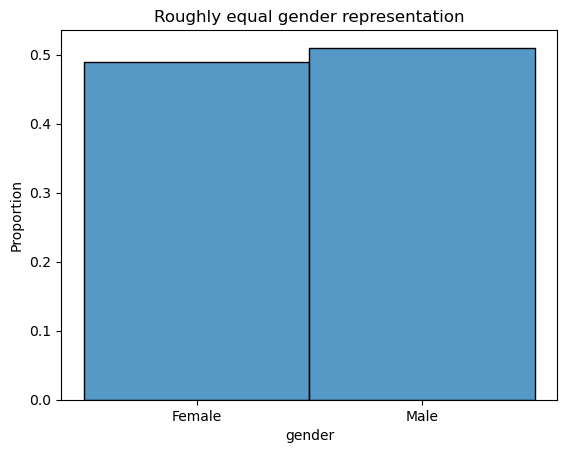

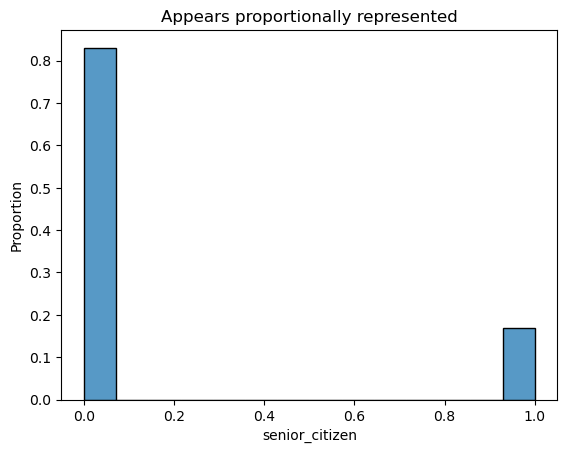

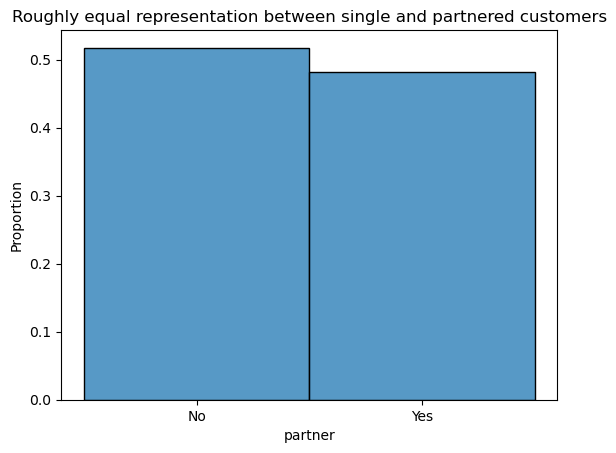

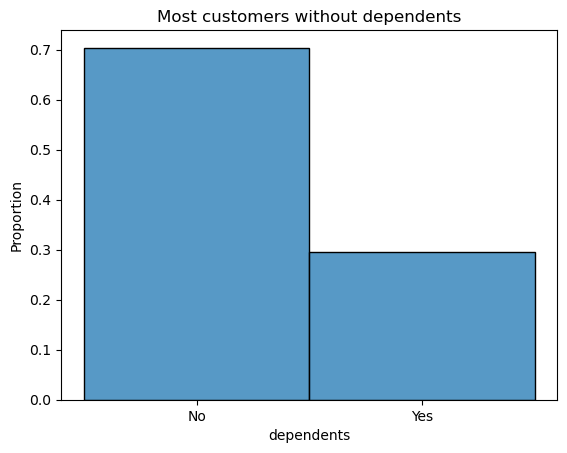

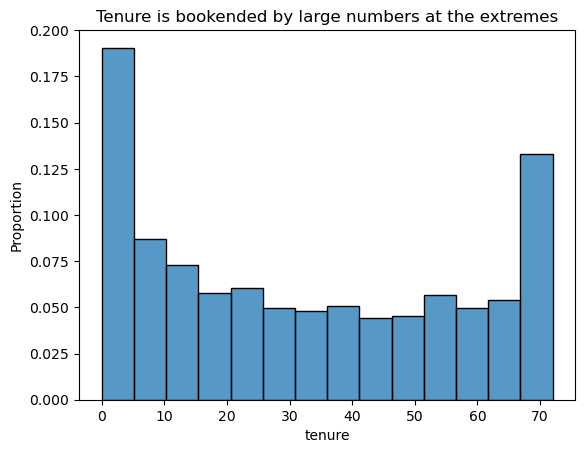

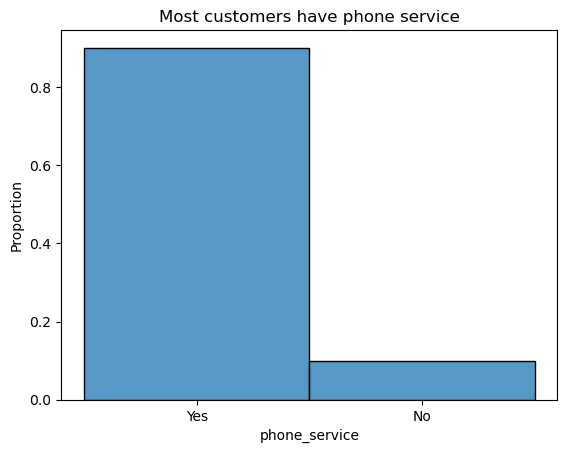

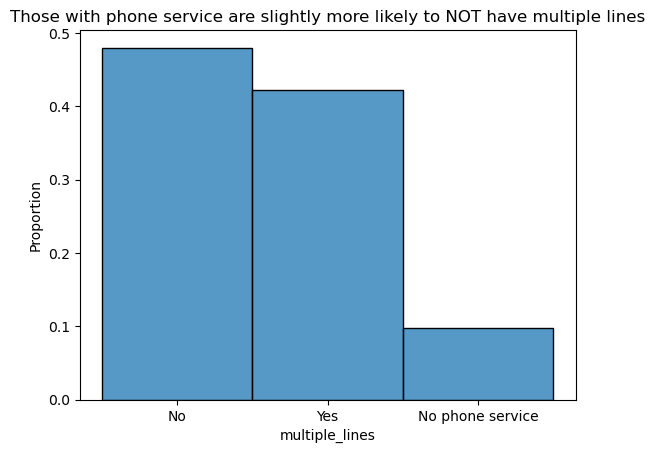

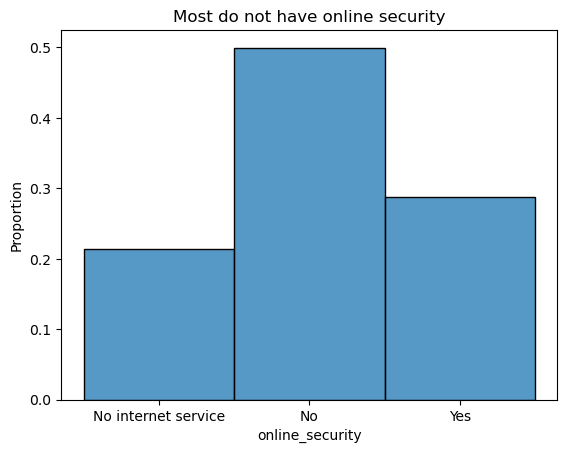

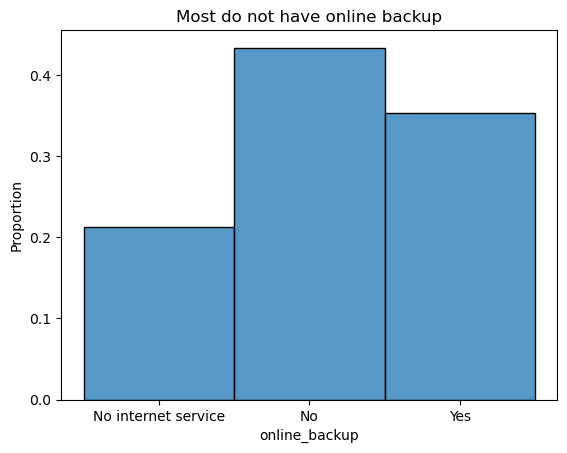

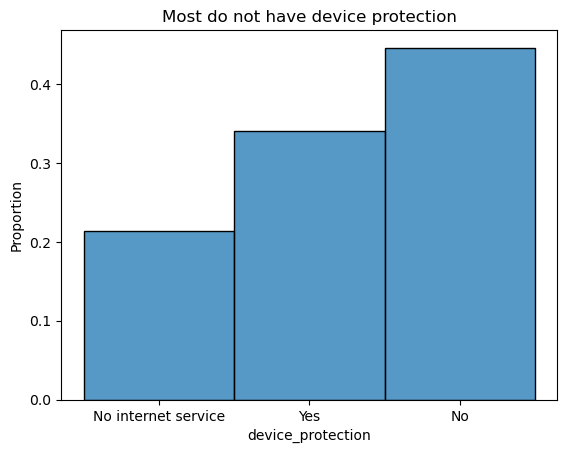

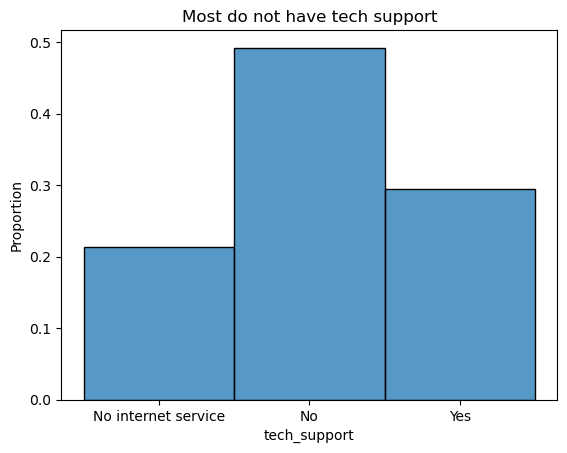

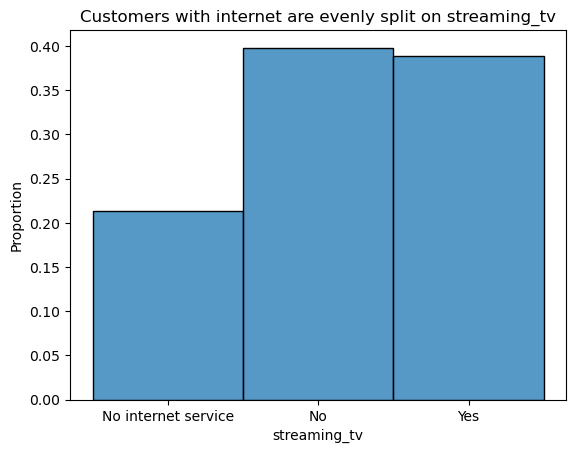

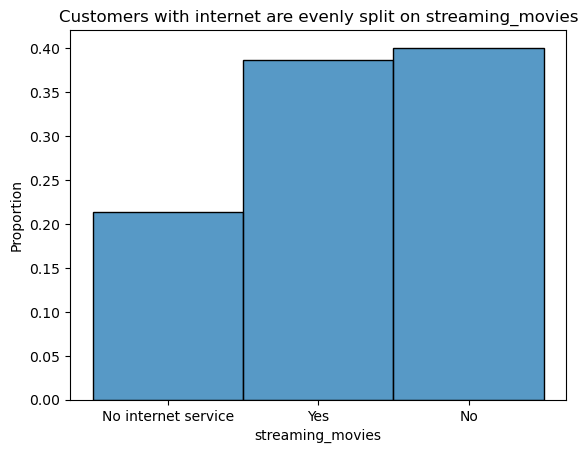

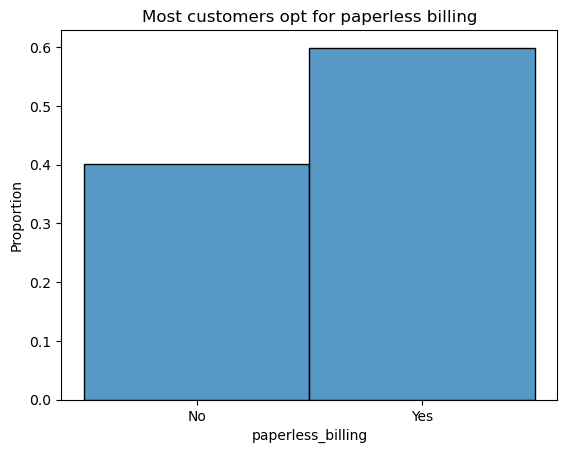

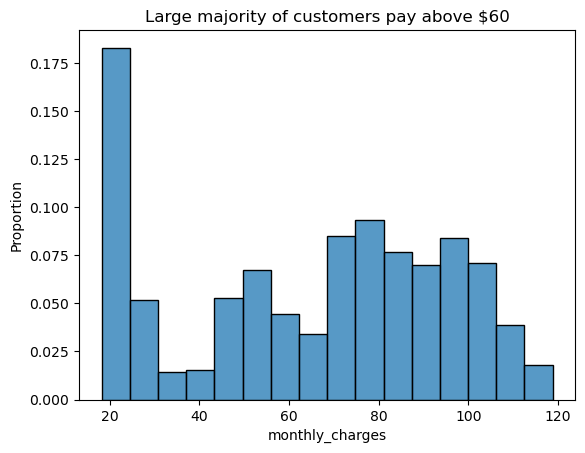

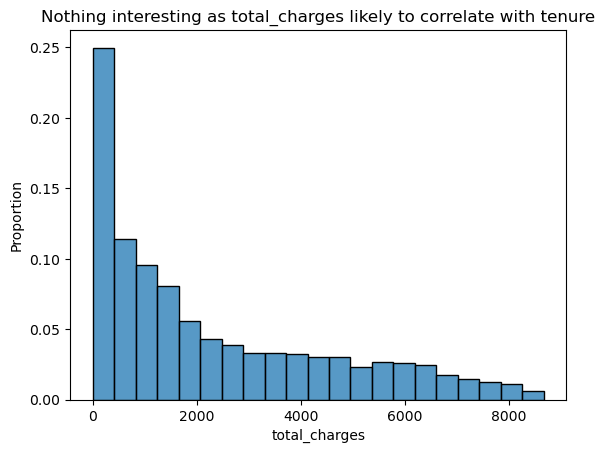

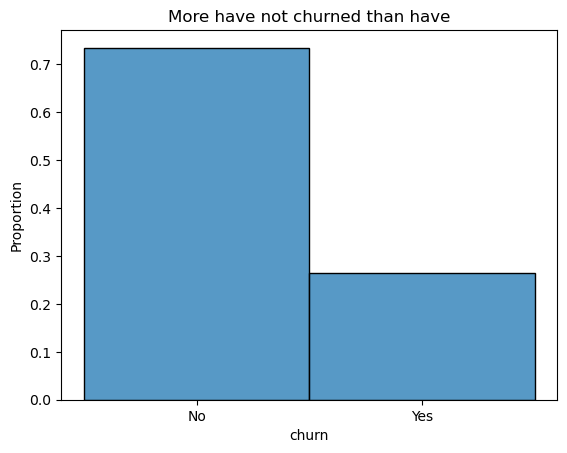

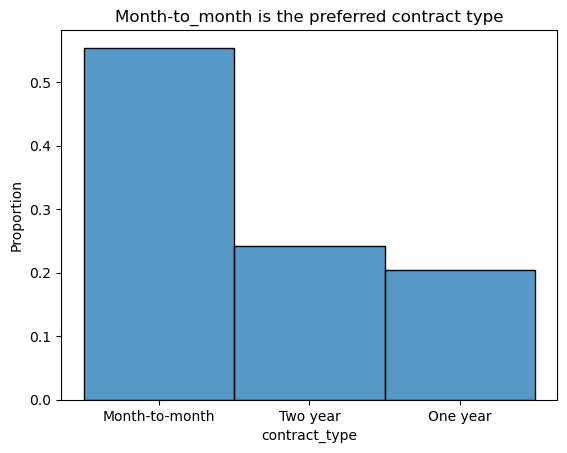

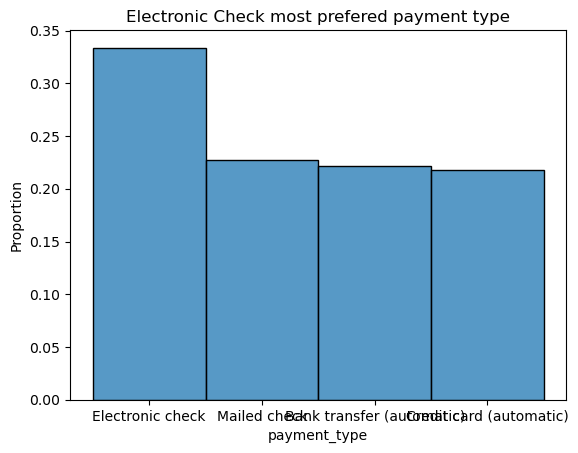

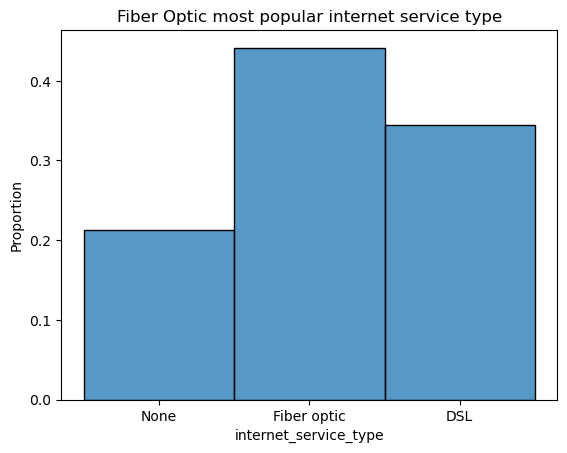

In [14]:
# loop through columns and display (with takeaway title) 
for col in telco:
    plt.title(univariate_takeways[col])
    sns.histplot(data=train, x=col, stat='proportion')
    plt.show()

### Univariate Takeaways
> Confirmed balanced split mentioned in **Prepare** for most columns

> Takeaways from *imbalanced* features:
* 'dependents': 'Most customers without dependents',  
* 'tenure': 'Tenure is bookended by large numbers at the extremes',
* 'phone_service': 'Most customers have phone service',
* 'multiple_lines': 'Those with phone service are slightly more likely to NOT have multiple lines',
* 'online_security': 'Most do not have online security',
* 'online_backup': 'Most do not have online backup',
* 'device_protection': 'Most do not have device protection',
* 'tech_support': 'Most do not have tech support',
* 'paperless_billing': 'Most customers opt for paperless billing',
* 'contract_type': 'Month-to_month is the preferred contract type',
* 'payment_type': 'Electronic Check most prefered payment type',
* 'internet_service_type': 'Fiber Optic most popular internet service type'


## Bivariate
Visuals exploring relationship between churn (target) and other features

In [15]:
#create title dictionary to later backfill
bivariate_takeaways = {
 'gender': 'Roughly equal gender representation in churn vs no_churn',
 'senior_citizen': 'Greater proportion of churned than population**',
 'partner': 'Single customers make up greater proportion of churned**',
 'dependents': 'Most customers without sependents',
 'tenure': 'Longer tenure seems associated with less churn**',
 'phone_service': 'Seems to have no change in churn vs no churn',
 'multiple_lines': 'Minimal change between churn/no_churn',
 'online_security': 'High level of churned had no online security',
 'online_backup': 'High level of churned had no online backup',
 'device_protection': 'High level of churned had no device_protection',
 'tech_support': 'High level of churned had no online security',
 'streaming_tv': 'Slightly higher percentage of churned had no streaming tv. A reversal from no churn',
 'streaming_movies': 'Roughly equal proportions of streaming optinos churned/no churn',
 'paperless_billing': 'Opting for paperless billing makes up greater portion of churned',
 'monthly_charges': 'Churned customers have higher than average bills**',
 'total_charges': 'Nothing interesting',
 'churn': '-----------',
 'contract_type': 'Month-to_month make up much greater proportion of churned**',
 'payment_type': 'Electronic check more highly represented among churned vs no churn',
 'internet_service_type': 'Fiber Optic overrepresented among the churned**'}

In [16]:
fiber = train[train.internet_service_type == 'Fiber optic']

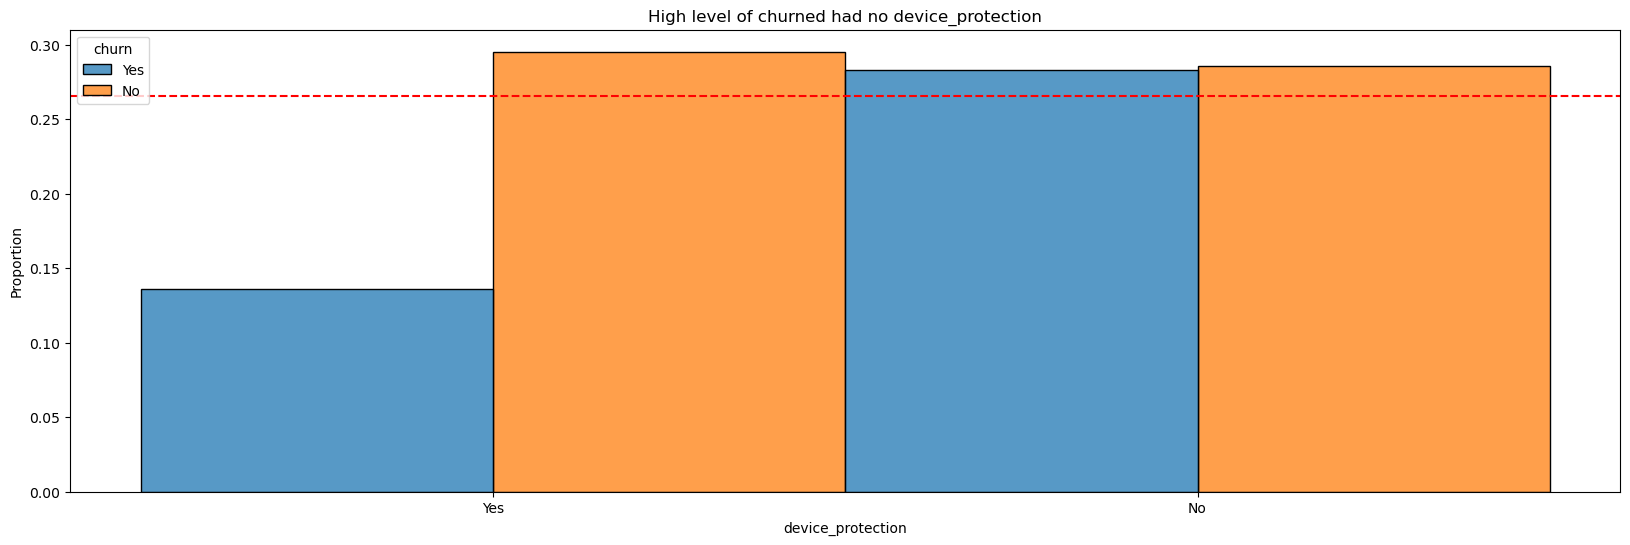

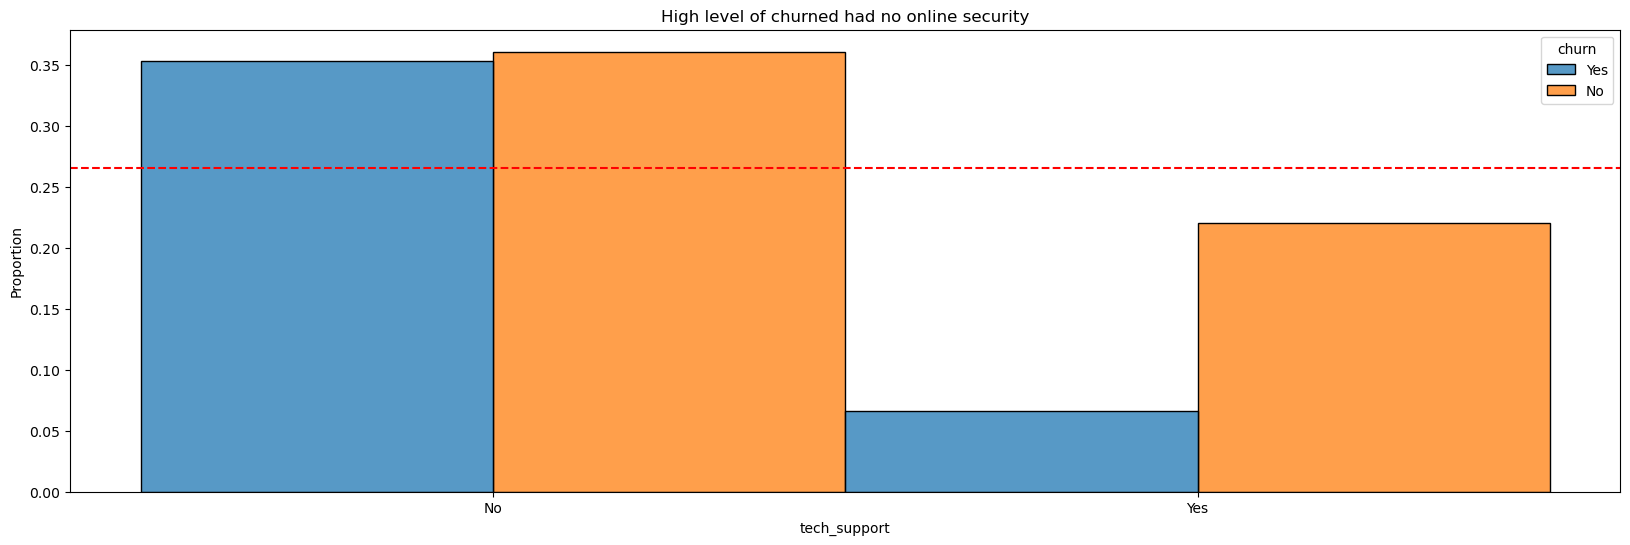

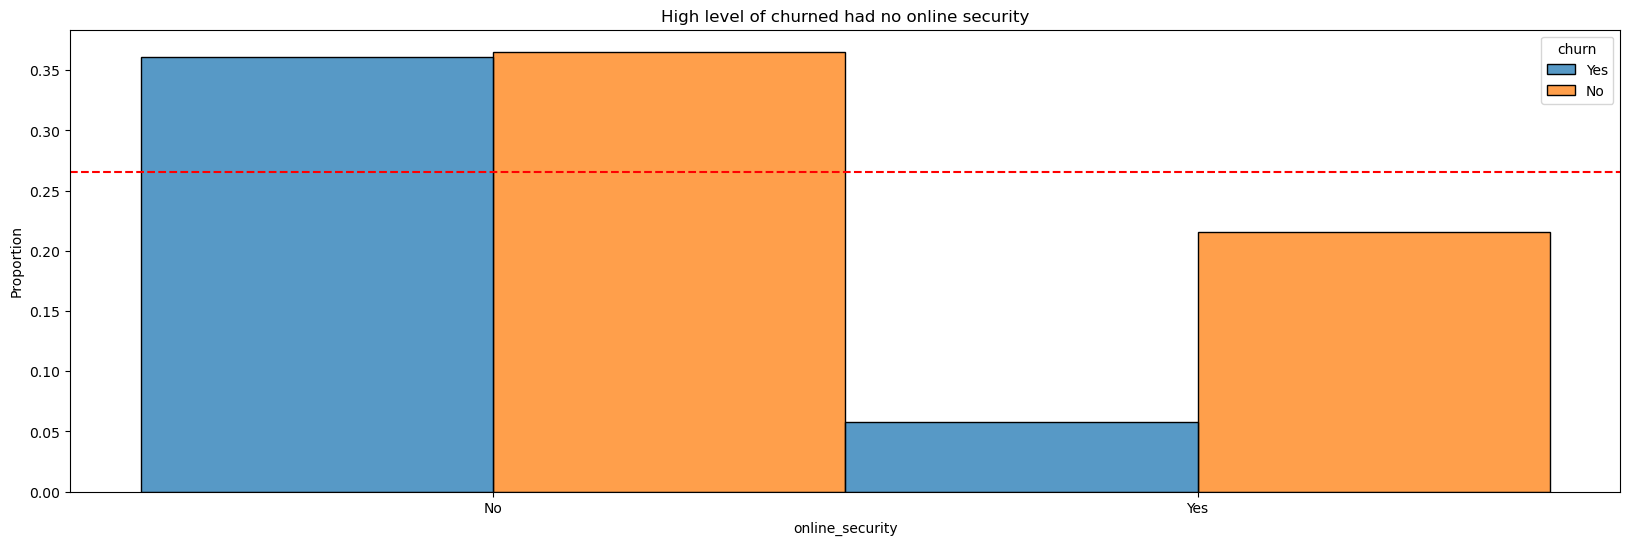

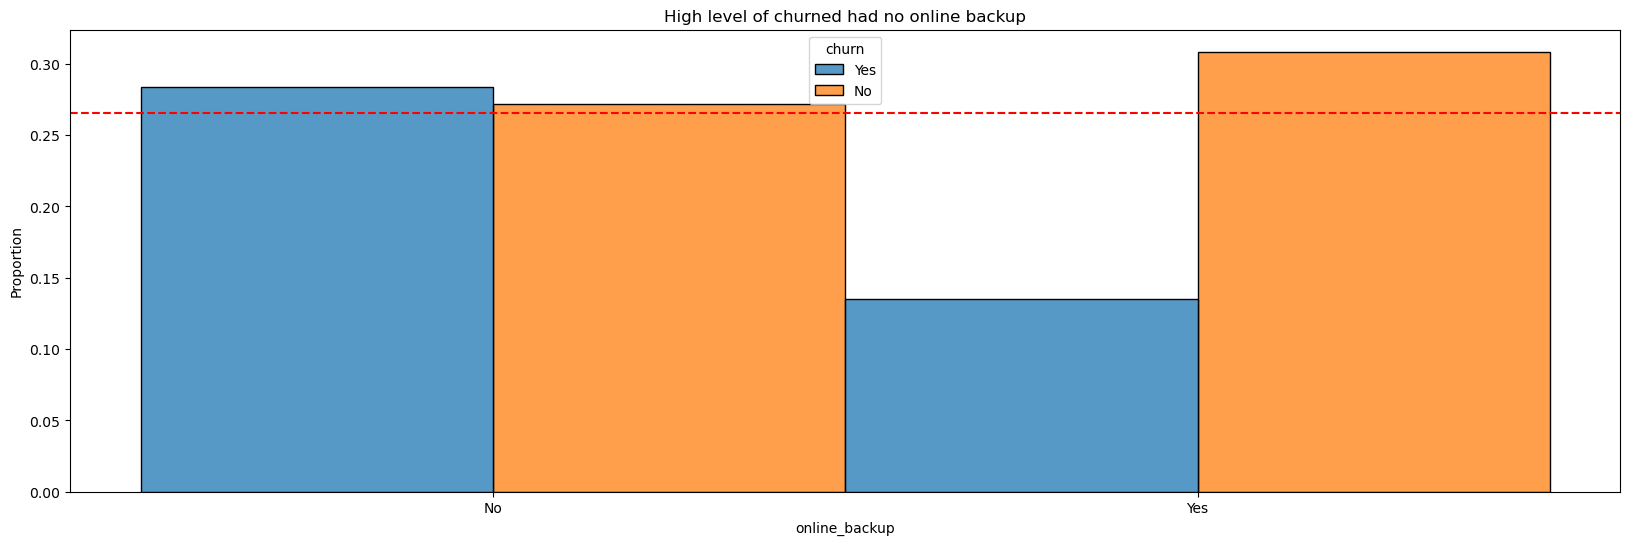

In [17]:
for col in ['device_protection', 'tech_support', 'online_security', 
            'online_backup']:
    plt.figure(figsize=(20,6))
    sns.histplot(data=fiber, x=col, hue='churn', multiple='dodge',  
                stat='proportion')
    plt.axhline(y=train.churn_encoded.mean(), color='red', linestyle='dashed', label='Population Churn Rate')
    plt.title(bivariate_takeaways[col])
    plt.show()

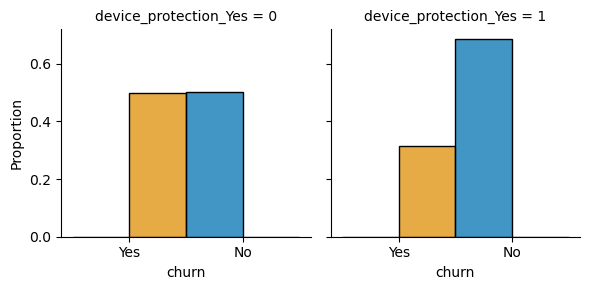

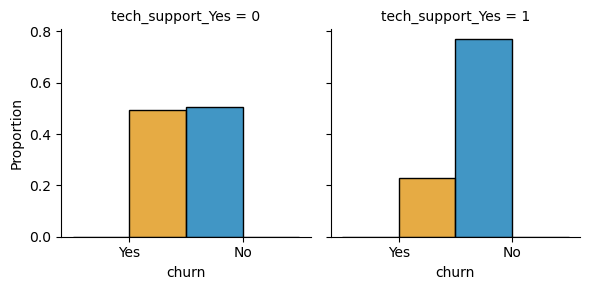

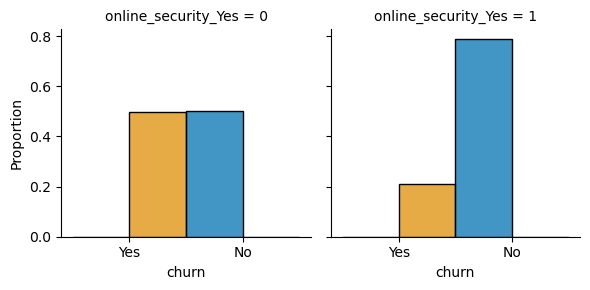

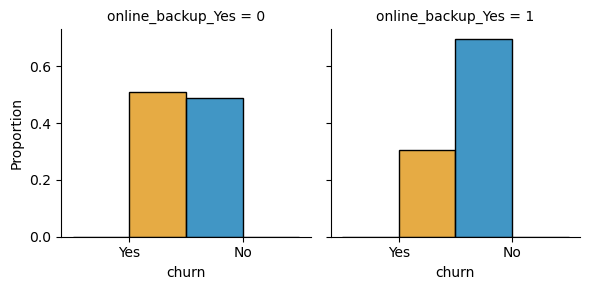

In [18]:
fiber_explore = ['device_protection_Yes', 'tech_support_Yes', 'online_security_Yes', 'online_backup_Yes']
#figure out way to make the columns appear in order
for col in fiber_explore:
    sns.set_palette('colorblind')
    g = sns.FacetGrid(data=fiber, col=col)
    g.map_dataframe(sns.histplot, x='churn', stat="proportion", hue='churn', hue_order=['No', 'Yes'], multiple='dodge')
    #viz_biv.fig.suptitle(fiber_explore[col], y=1.05)
    #g.set(xlabel=None, ylabel=None)
    #g.set_titles('')
    #g.set_xticklabels([]);

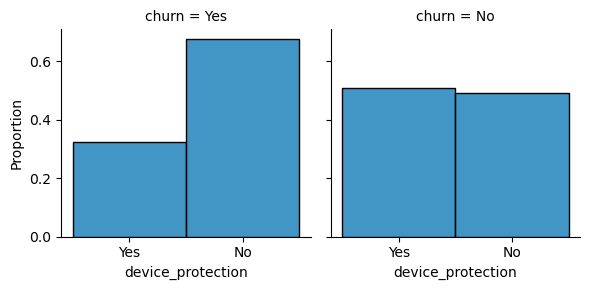

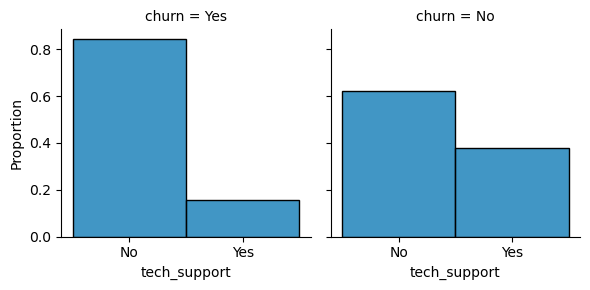

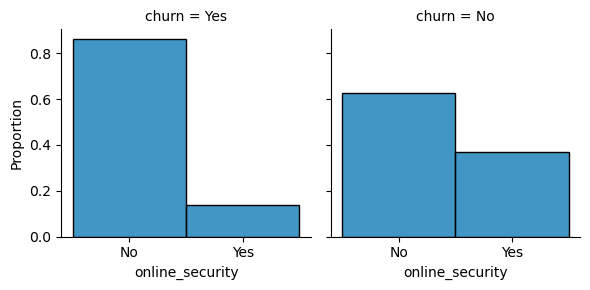

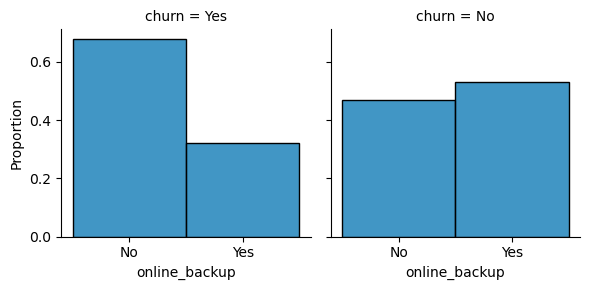

In [19]:
fiber_explore = ['device_protection', 'tech_support', 'online_security',
                 'online_backup']
#figure out way to make the columns appear in order
for col in fiber_explore:
    viz_biv = sns.FacetGrid(data=fiber, col='churn')
    viz_biv.map_dataframe(sns.histplot, x=col, stat="proportion", multiple='dodge')
    #viz_biv.fig.suptitle(fiber_explore[col], y=1.05)

In [20]:
print(train[train.churn_encoded == 0].monthly_charges.mean())
print(train[train.churn_encoded == 1].monthly_charges.mean())

61.49275128865977
74.5369759143622


In [21]:
#fiber customers that have churned by contract type
print(fiber[fiber.churn_encoded == 1]['contract_type']
    .value_counts(normalize=True))

#not churned
print(fiber[fiber.churn_encoded == 0]['contract_type']
    .value_counts(normalize=True))


Month-to-month    0.898977
One year          0.079284
Two year          0.021739
Name: contract_type, dtype: float64
Month-to-month    0.528598
One year          0.248155
Two year          0.223247
Name: contract_type, dtype: float64


In [22]:
for col in fiber_explore:
    print(fiber[fiber.churn_encoded == 1][col].value_counts(normalize=True))

No     0.675192
Yes    0.324808
Name: device_protection, dtype: float64
No     0.842711
Yes    0.157289
Name: tech_support, dtype: float64
No     0.861893
Yes    0.138107
Name: online_security, dtype: float64
No     0.677749
Yes    0.322251
Name: online_backup, dtype: float64


In [23]:
for col in fiber_explore:
    #print(train[(train.churn_encoded == 1) & (train.internet_service_type_None == 0)][col].value_counts(normalize=True))
    print(train[train[col] == 'Yes'].churn_encoded.value_counts(normalize=True))

0    0.780556
1    0.219444
Name: churn_encoded, dtype: float64
0    0.849678
1    0.150322
Name: churn_encoded, dtype: float64
0    0.860676
1    0.139324
Name: churn_encoded, dtype: float64
0    0.783367
1    0.216633
Name: churn_encoded, dtype: float64


<AxesSubplot:>

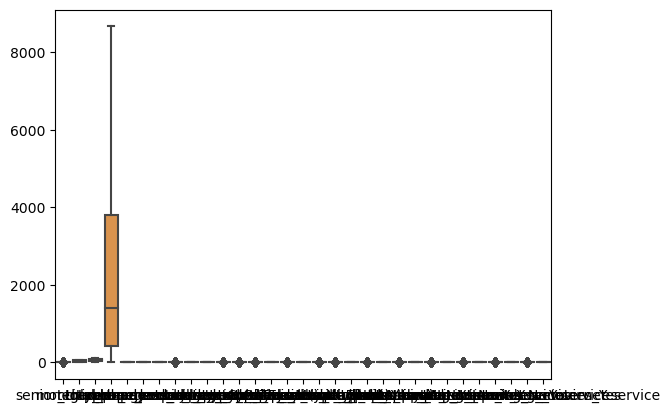

In [24]:
sns.boxplot(data=train)

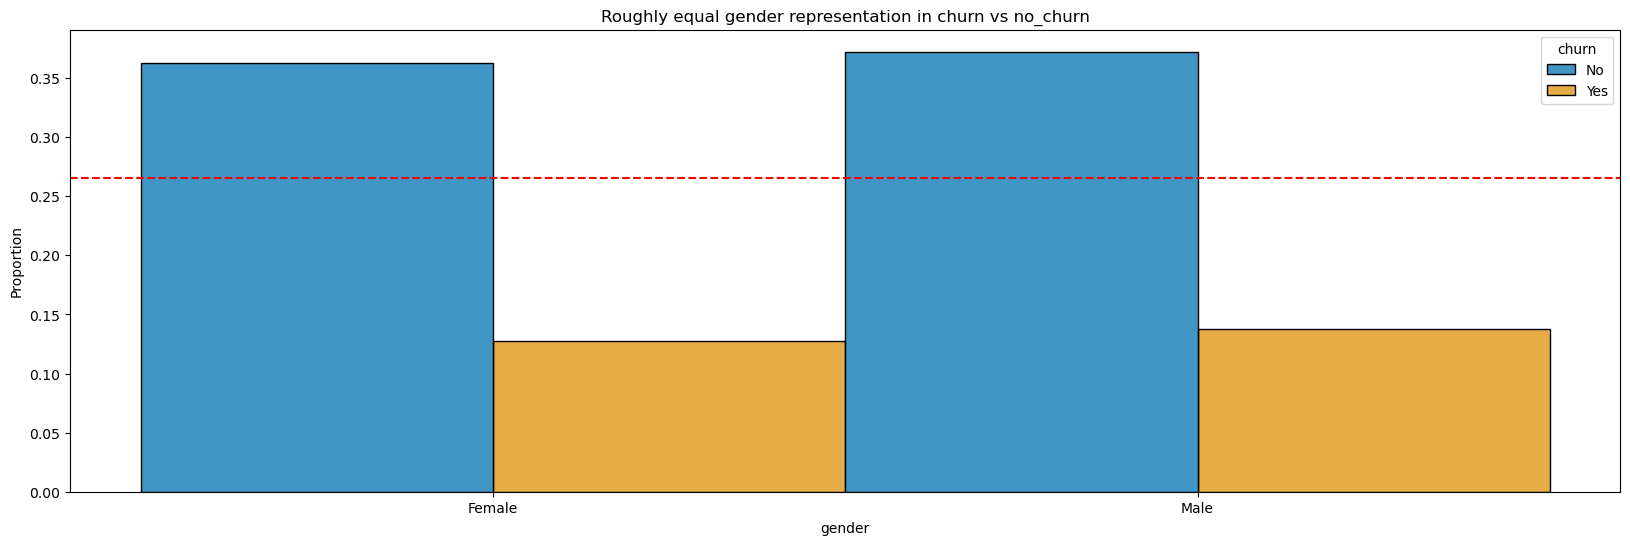

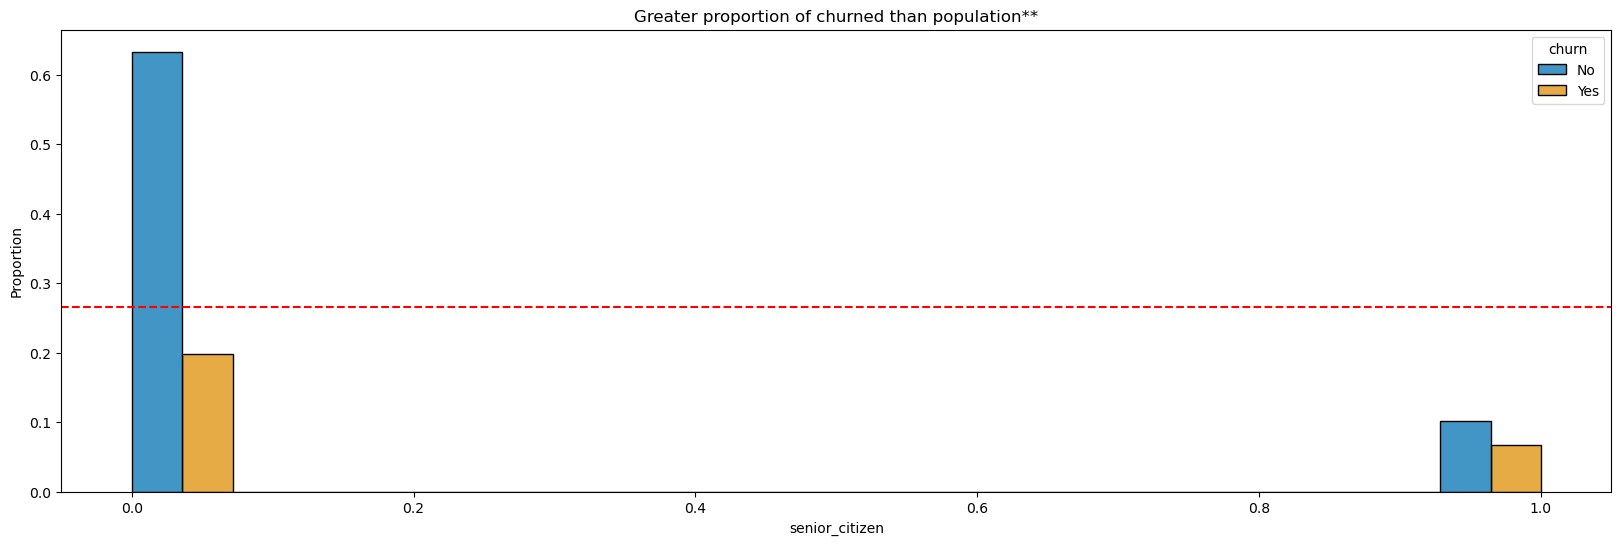

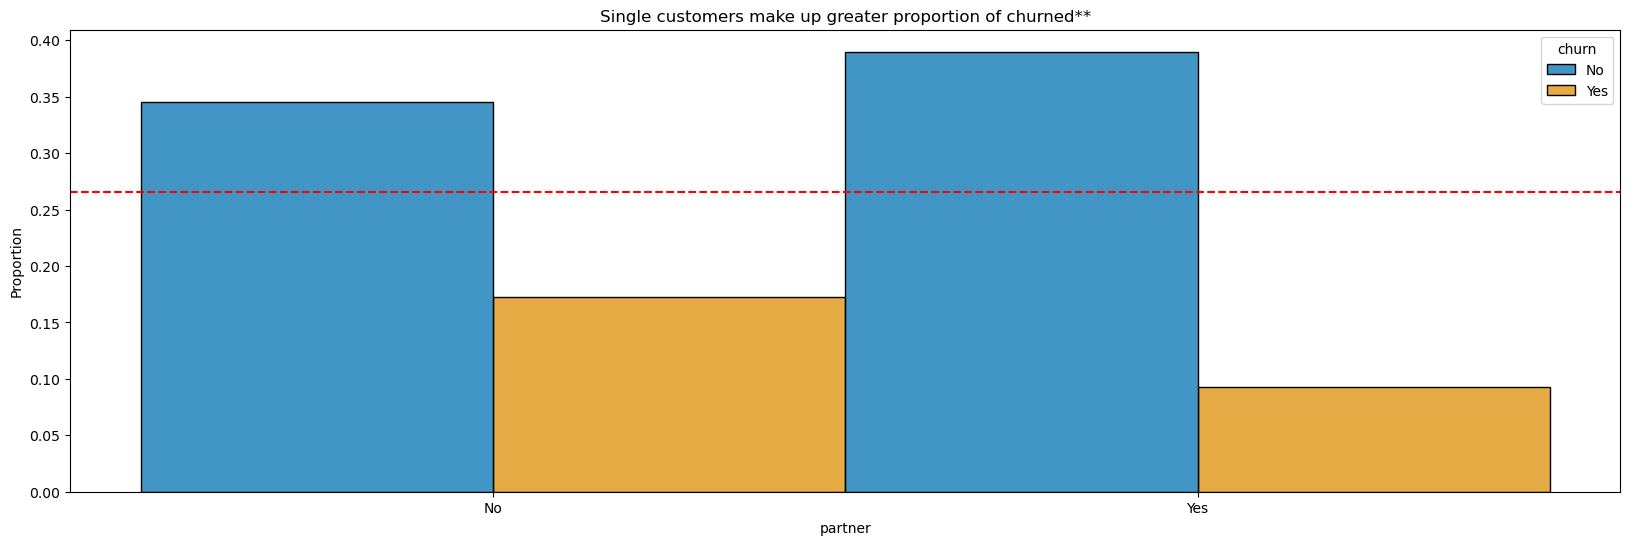

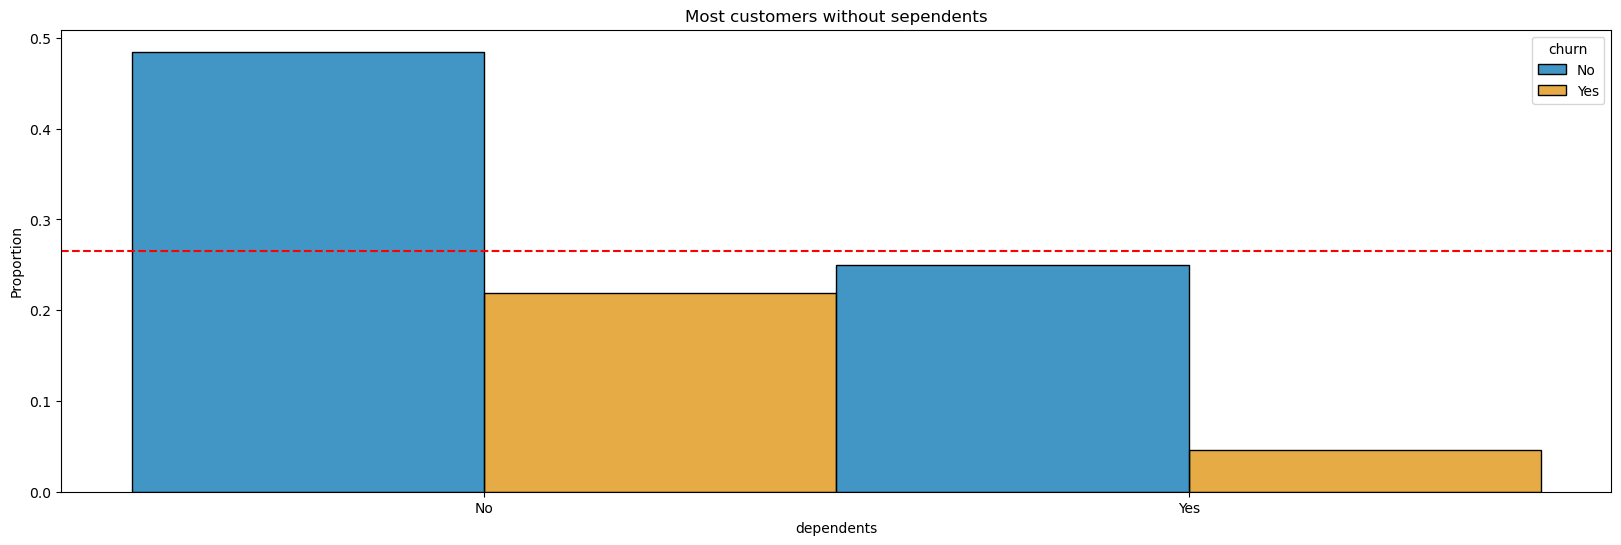

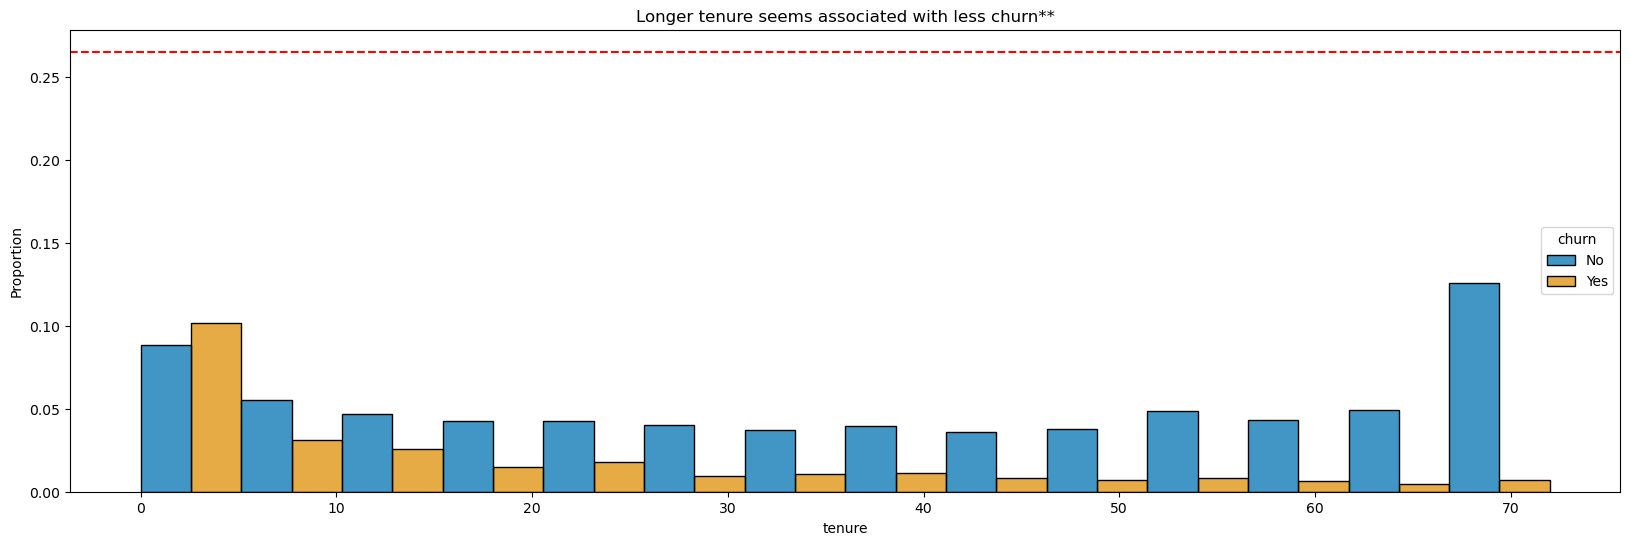

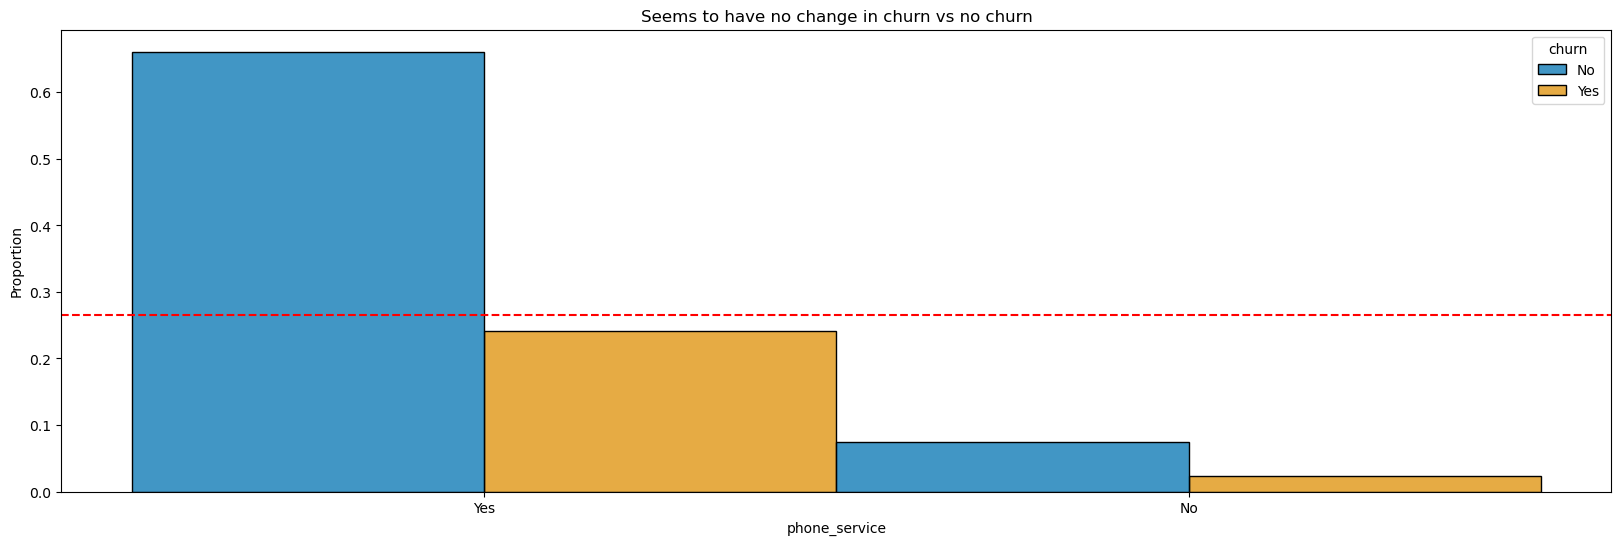

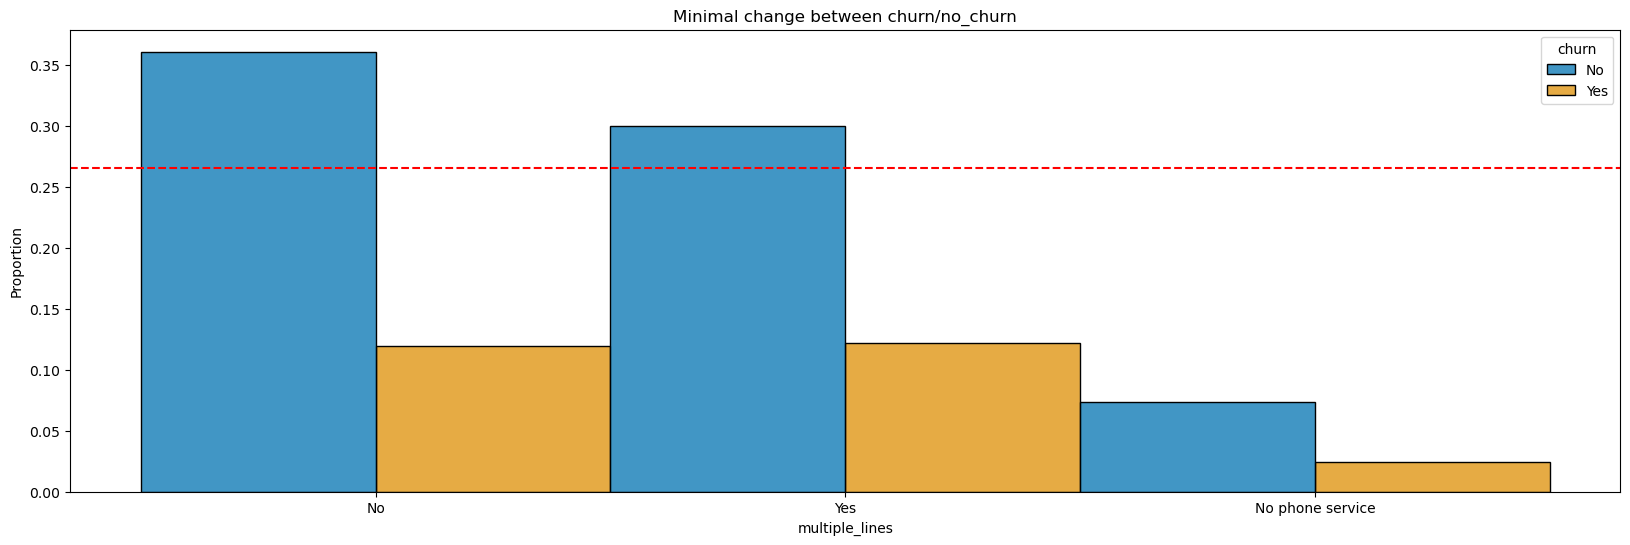

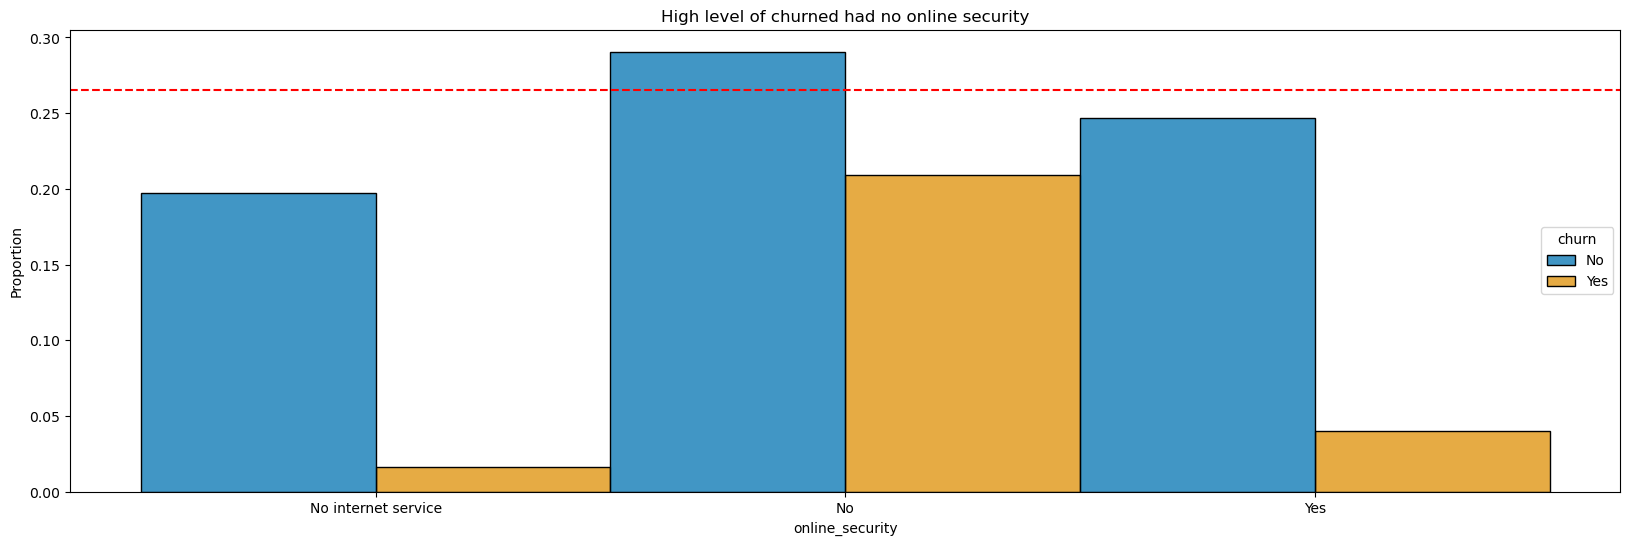

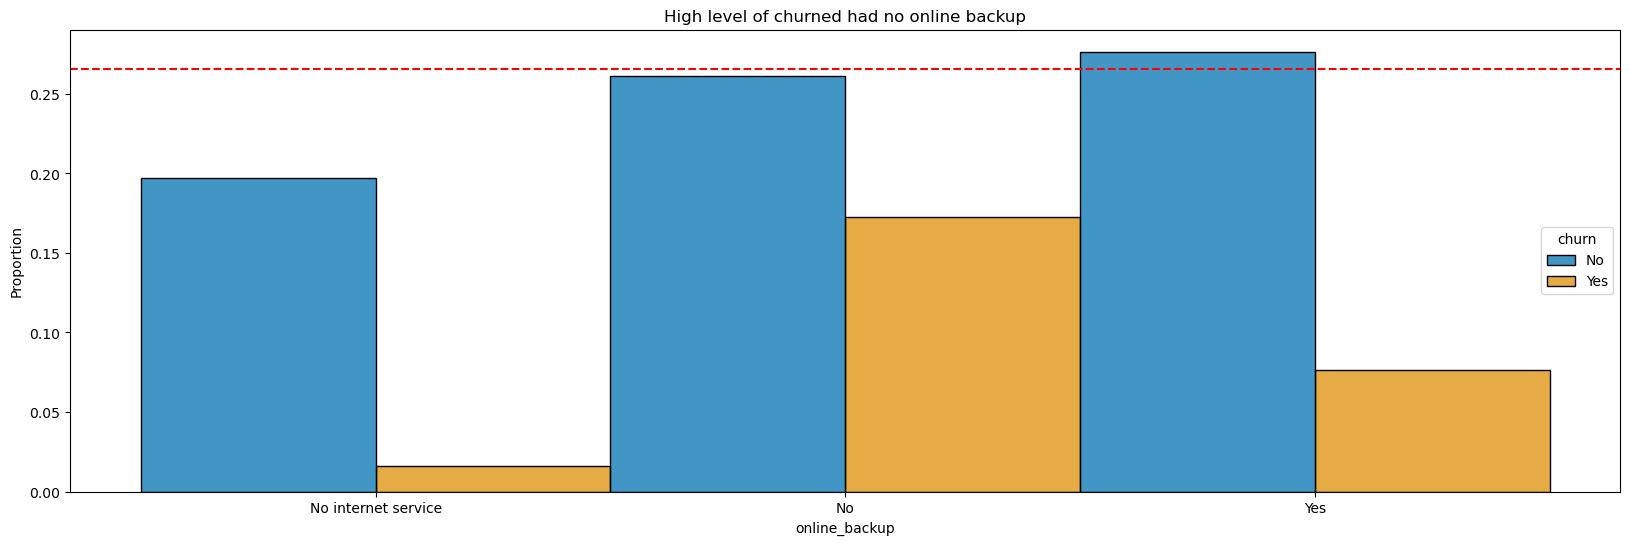

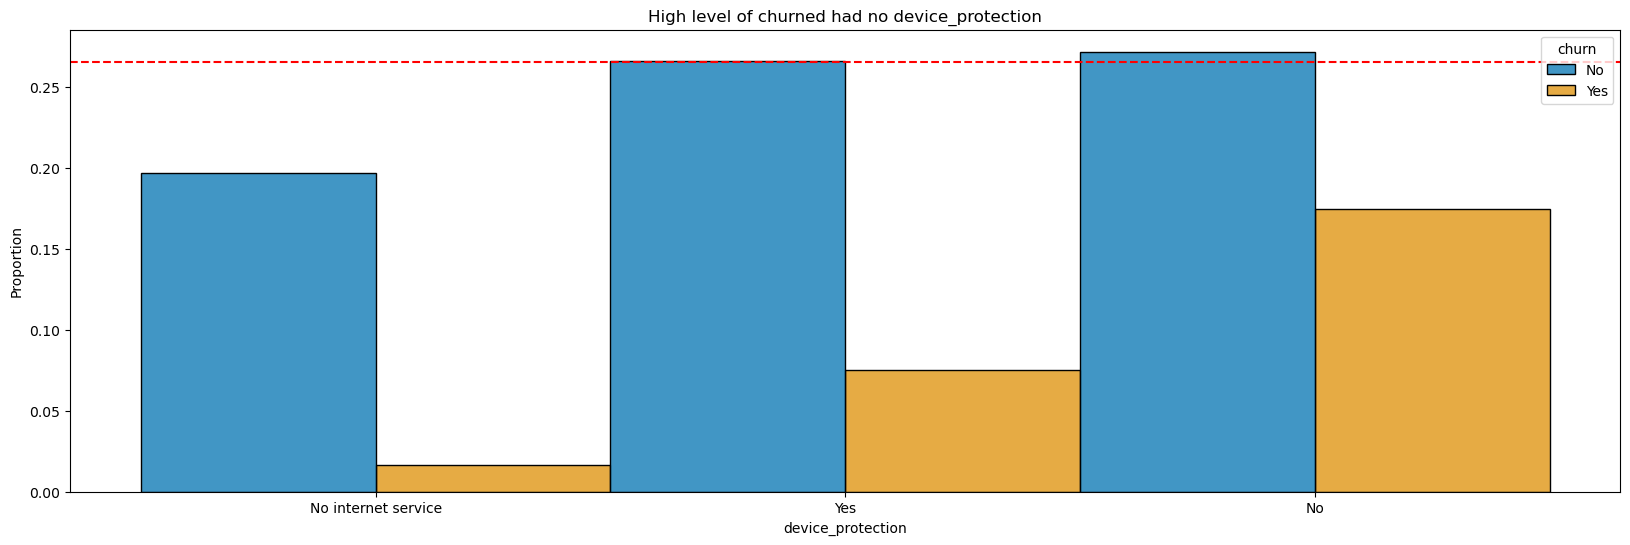

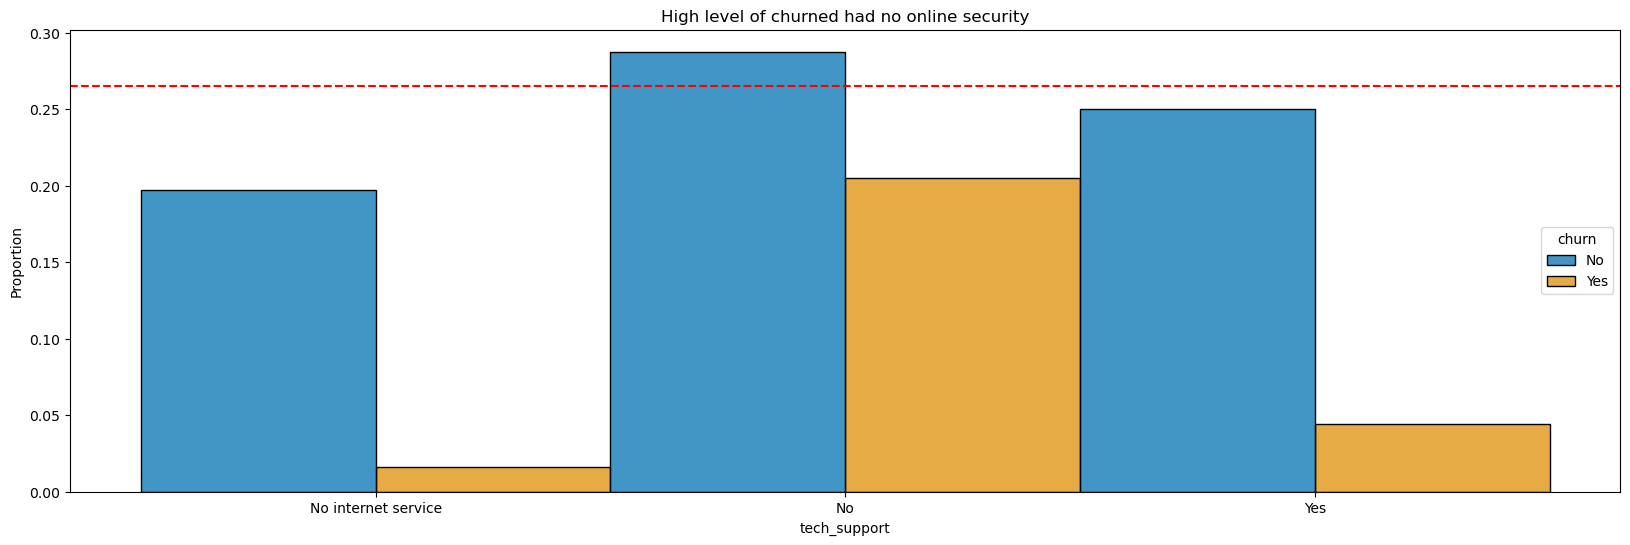

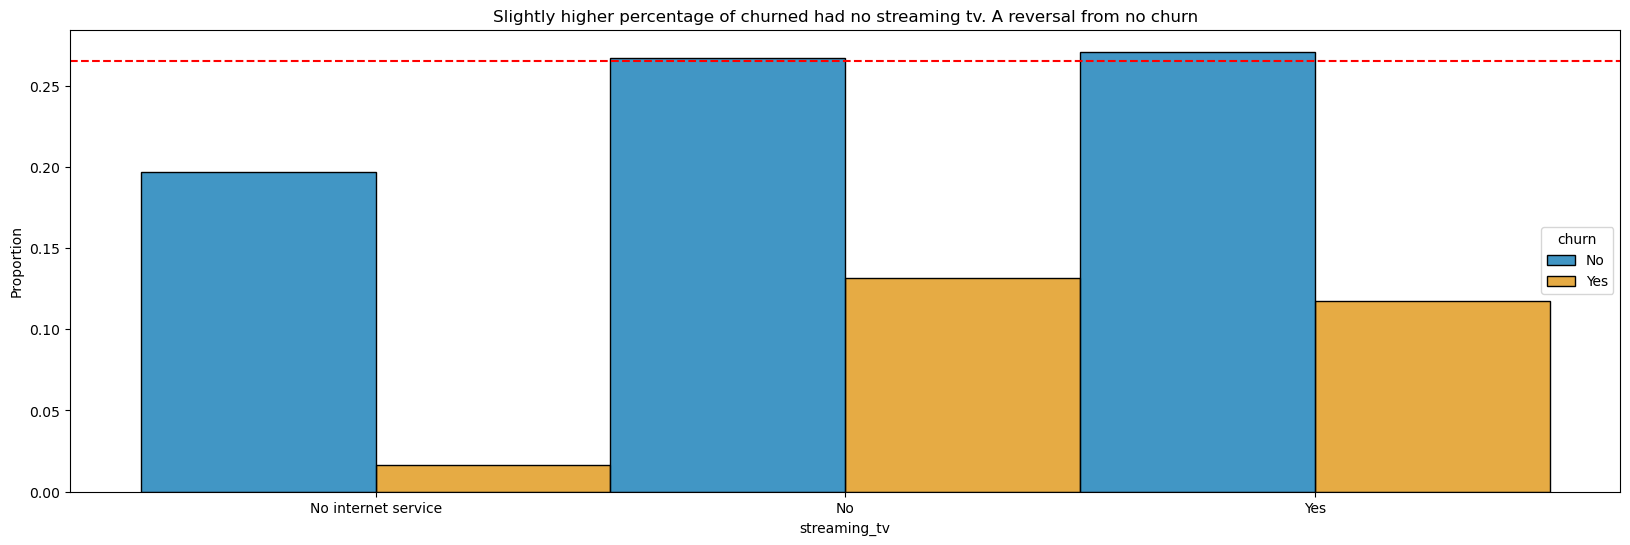

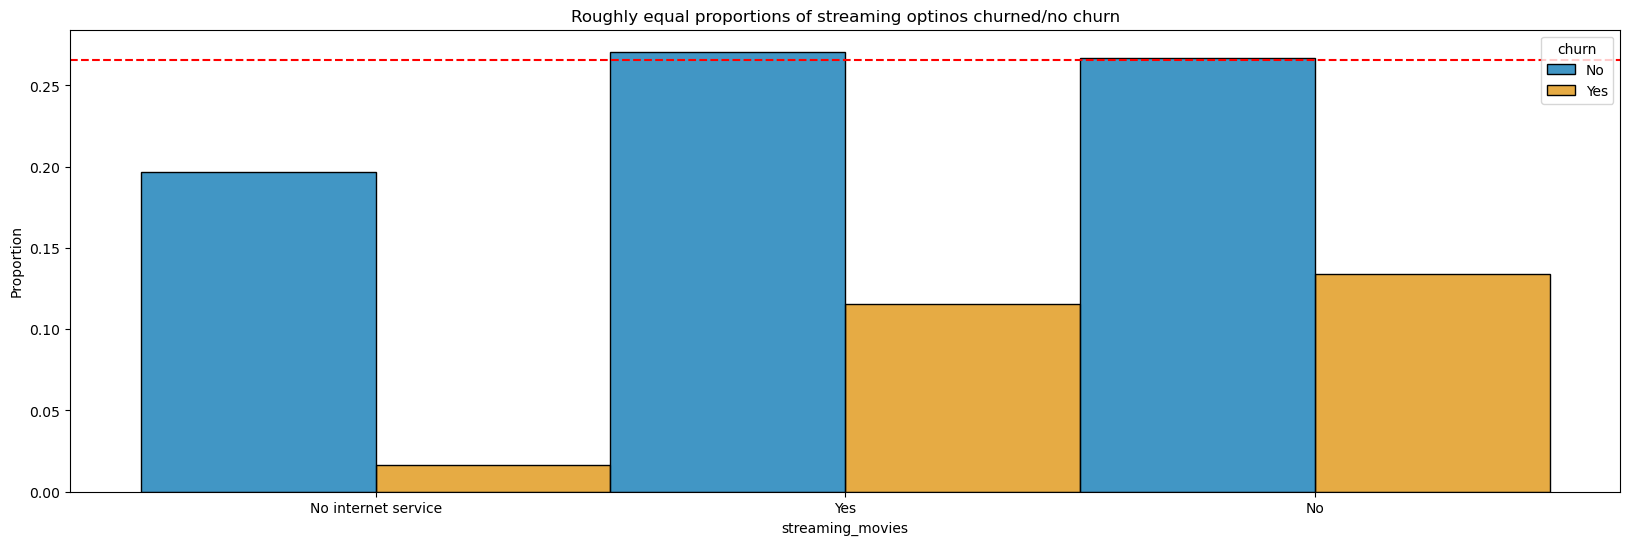

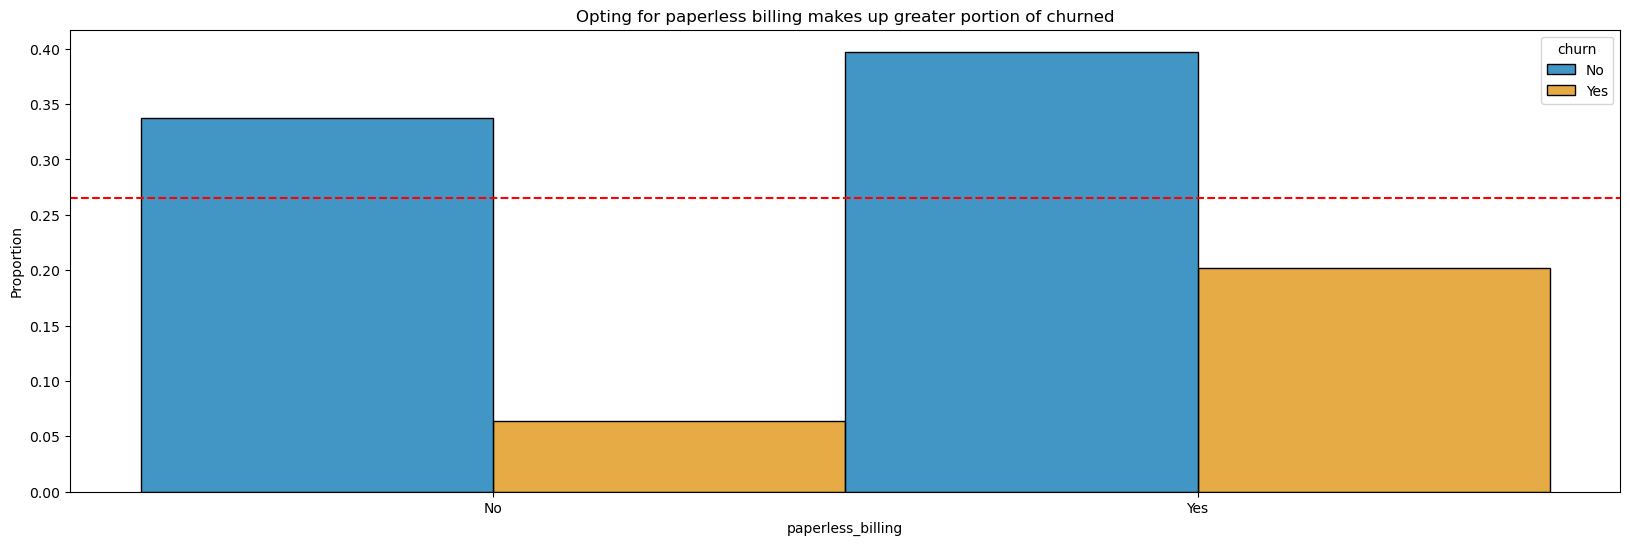

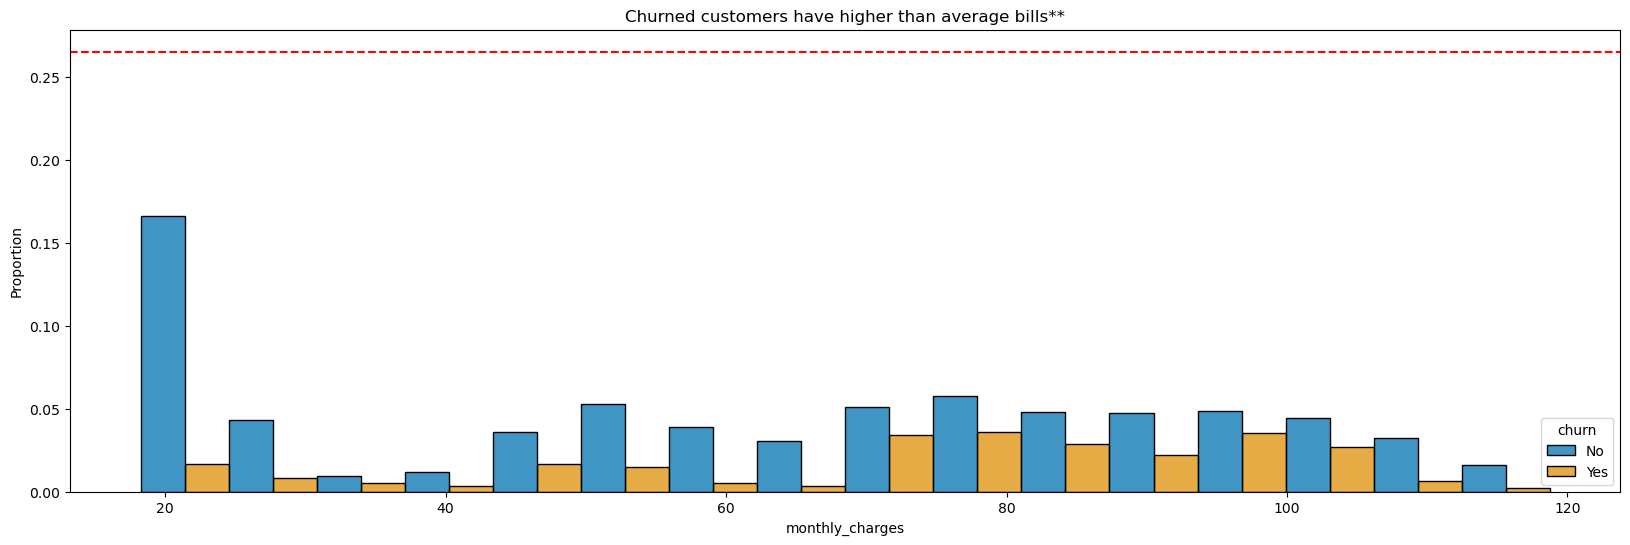

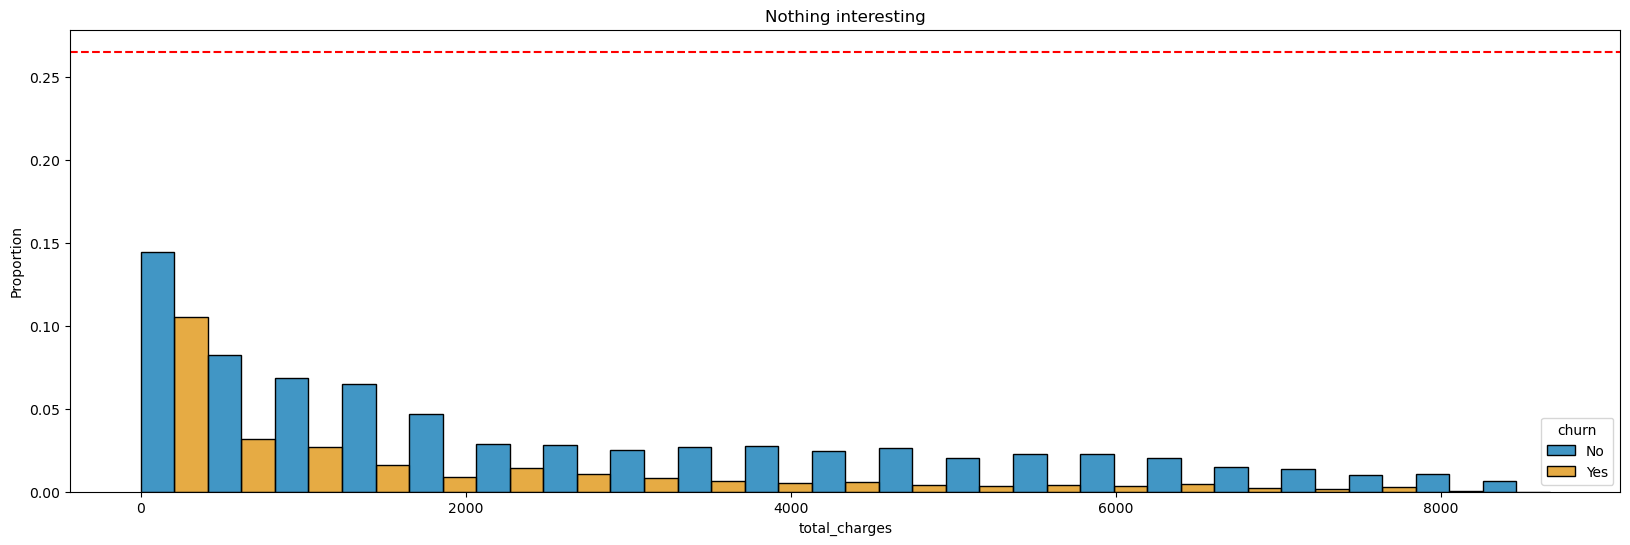

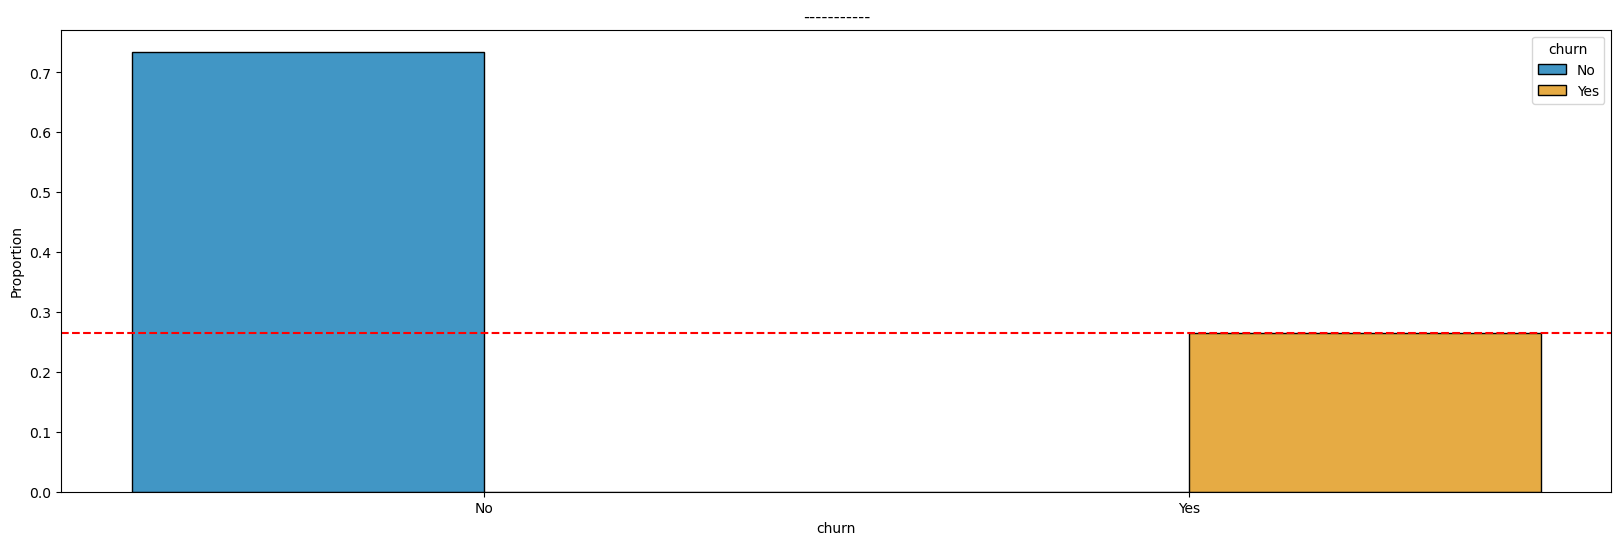

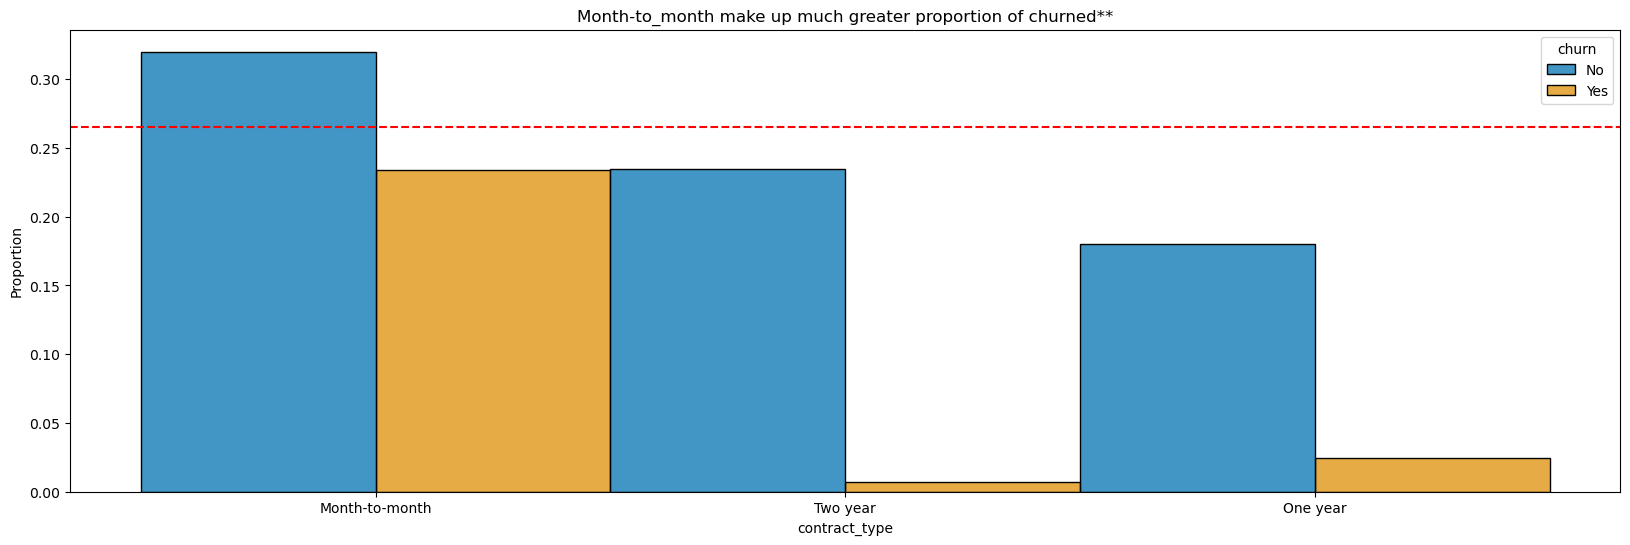

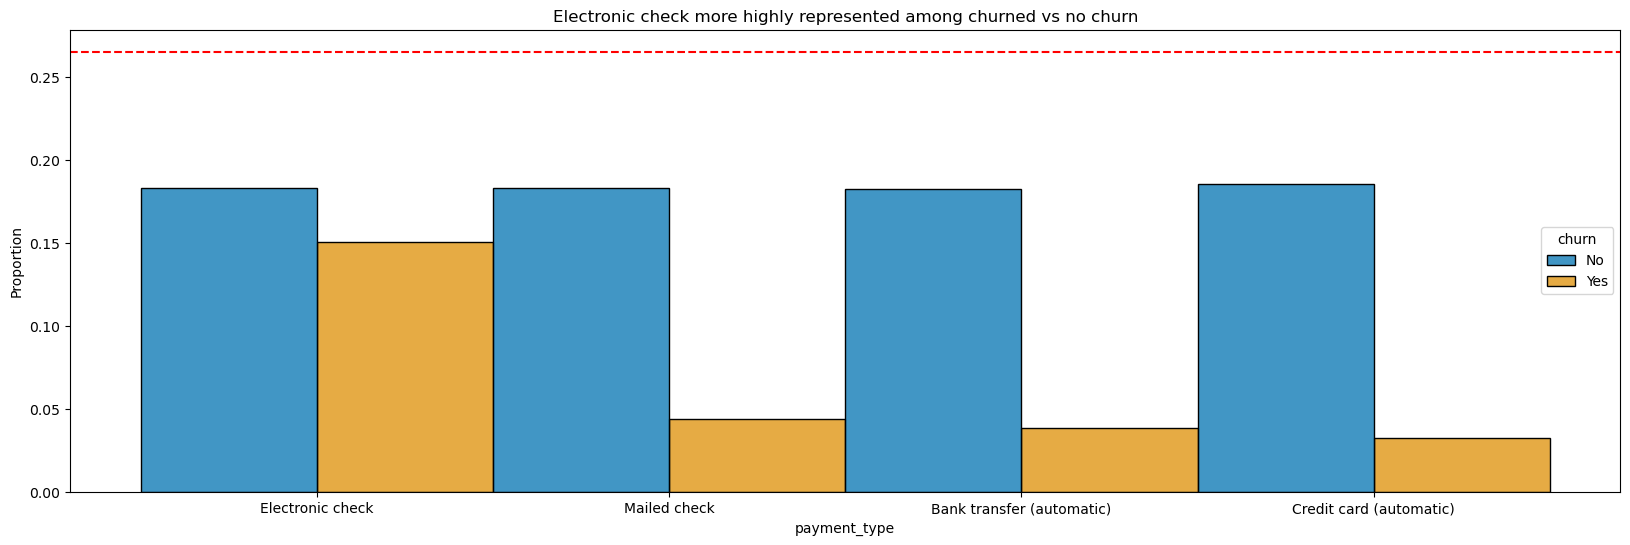

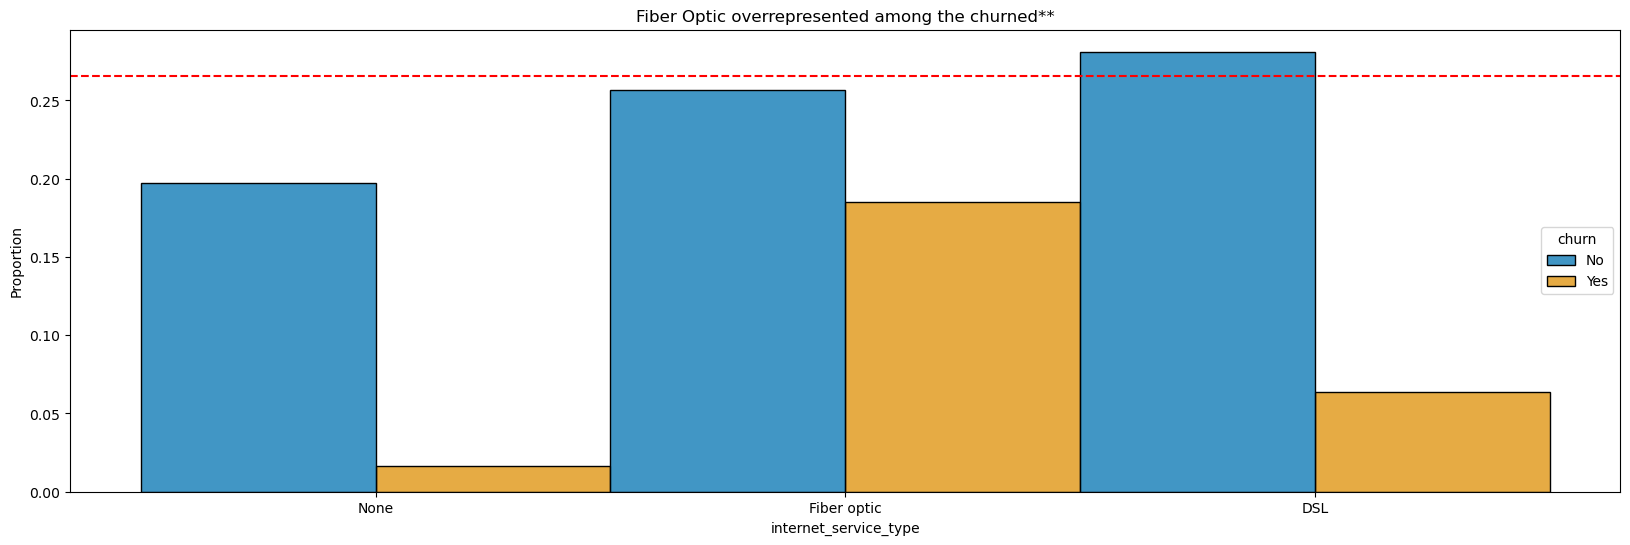

In [25]:
for col in telco:
    plt.figure(figsize=(20,6))
    sns.histplot(data=train, x=col, hue='churn', multiple='dodge', stat='proportion')
    plt.axhline(y=train.churn_encoded.mean(), color='red', linestyle='dashed', label='Population Churn Rate')
    plt.title(bivariate_takeaways[col])
    plt.show()

In [26]:
# create dictionary to hold titles for takeaways from second set of bivariate visuals
bivariate_b_titles = {'partner': '\"No\" partner rate increased among churned customers',\
                    'tenure': 'Churn heavily skewed towards lower tenured customers',\
                    'contract_type': '~80% of churned on month-to-month contracts',\
                    'internet_service_type': 'Fiber customers make up well over 60% of churn customers'}

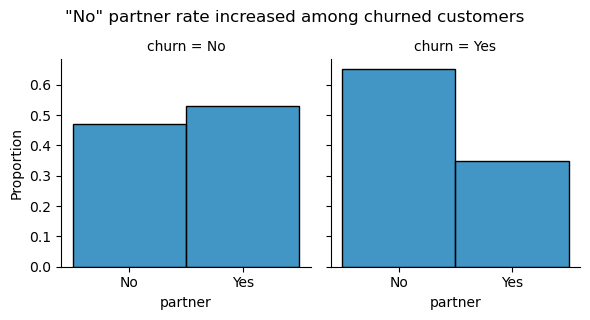

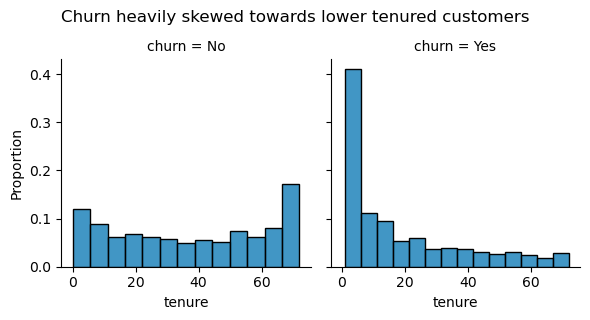

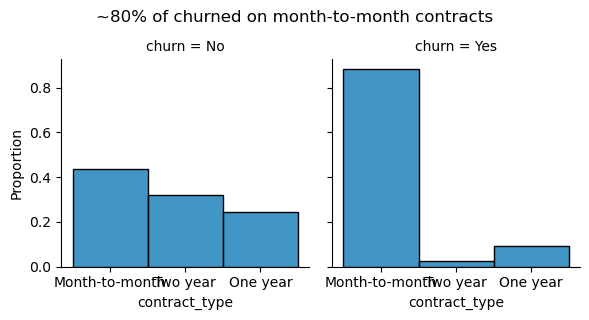

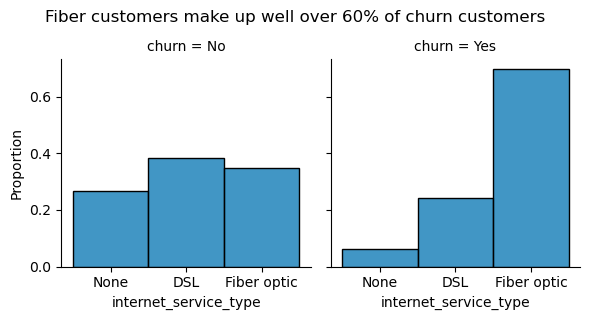

In [27]:
# create different visuals for columns identified above for further exploration or improved clarity
bivariate_b = ['partner', 'tenure', 'contract_type', 'internet_service_type']
for col in bivariate_b:
    viz_biv = sns.FacetGrid(data=train, col='churn')
    viz_biv.map_dataframe(sns.histplot, x=col, stat="proportion", multiple='dodge')
    viz_biv.fig.suptitle(bivariate_b_titles[col], y=1.05)

Text(0.5, 0.98, 'More balanced churn porportions than other customer groups')

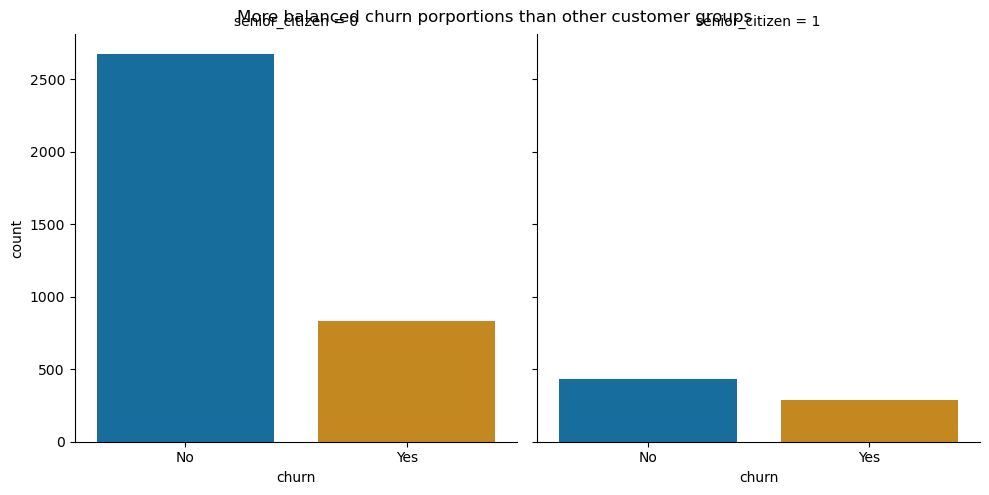

In [28]:
#need graph to see if 
sns.catplot(data=train, x='churn' , col='senior_citizen', kind='count') 
plt.suptitle('More balanced churn porportions than other customer groups')

### Bivariate Takeaways 
> Early Takeaways
* 'gender': 'Roughly equal gender representation in churn vs no_churn',
* 'senior_citizen': 'Greater proportion of churned than population**',
    * senior_citizen: More balanced churn porportions than other customer groups</br></br>

* 'partner': 'Single customers make up greater proportion of churned**',  
* 'dependents': 'Most customers without sependents',
* 'tenure': 'Longer tenure seems associated with less churn**',
* 'phone_service': 'Seems to have no change in churn vs no churn',
* 'multiple_lines': 'Minimal change between churn/no_churn',
* 'online_security': 'High level of churned had no online security',
* 'online_backup': 'High level of churned had no online backup',
* 'device_protection': 'High level of churned had no device_protection',
* 'tech_support': 'High level of churned had no online security',
* 'streaming_tv': 'Slightly higher percentage of churned had no streaming tv. A reversal from no churn',
* 'streaming_movies': 'Roughly equal proportions of streaming optinos churned/no churn',
* 'paperless_billing': 'Opting for paperless billing makes up greater portion of *churned',
* 'monthly_charges': 'Churned customers have higher than average bills**',
* 'total_charges': 'Nothing interesting',
* 'churn': '-----------',
* 'contract_type': 'Month-to_month make up much greater proportion of churned**',
* 'payment_type': 'Electronic check more highly represented among churned vs no churn',
*  'internet_service_type': 'Fiber Optic overrepresented among the churned**'}

> Further Takeaways --> Questions for Multivariate phase

* 'partner': '\"No\" partner rate increased among churned customers',

* 'tenure': 'Churn heavily skewed towards lower tenured customers',\
* 'contract_type': '~80% of churned on month-to-month contracts',\
* 'internet_service_type': 'Fiber customers make up well over 60% of churn customers'

> Column/Feature Creation --> Additional questions for Multivariate phase
* is alone??

## Multivariate
Explore questions that arose from Univariate and Bivariate phases

### Questions
* `churn` vs `contract_type` and `monthly_charges`
* `churn` vs `tenure` and `monthly_charges`
* `churn` vs `internet_service_type` and `monthly_charges`
* `churn` vs `tenure` and `internet_service_type`

##### Are there differences in the monthly charges and contract types that affect churn together?
* `churn` vs `contract_type` and `monthly_charges`
* Takeaway: Month-to-month customers seem more sensitive to higher prices than other groups

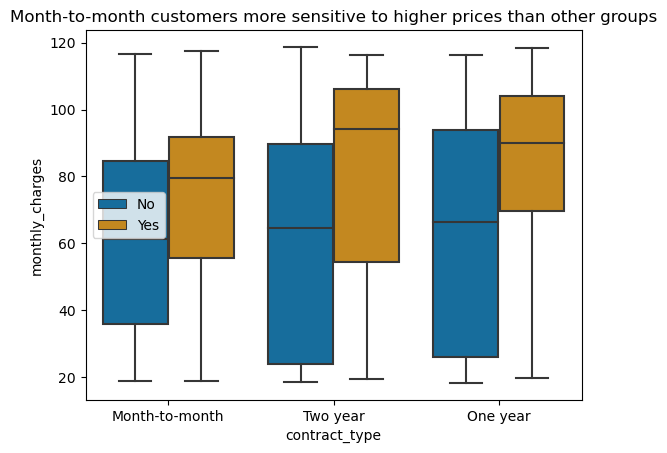

In [29]:
sns.boxplot(data=train, x='contract_type', y='monthly_charges', hue='churn')
plt.title('Month-to-month customers more sensitive to higher prices than other groups')
plt.legend()
plt.show()

#### Are customers less senstive to price over time?
* `churn` vs `tenure` and `monthly_charges`
* Takeaway: Customers with less than 20 months more sensitive to higher prices

In [30]:
tenure_bins = [0,12,24,36,48,60]
train['tenure_group']=pd.cut(train['tenure'],tenure_bins, include_lowest=True)

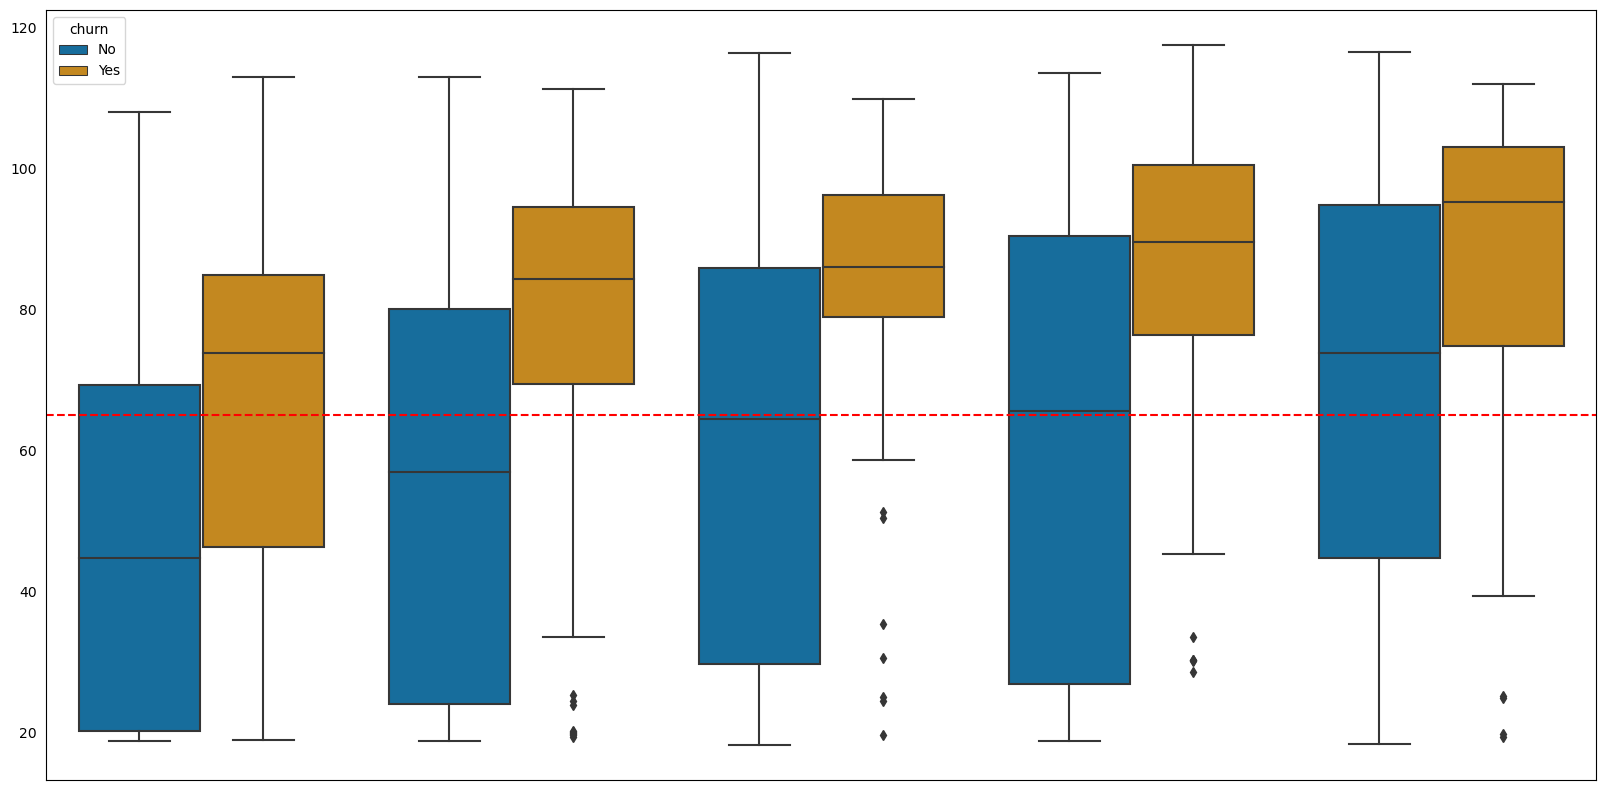

In [31]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=train, x='tenure_group', y='monthly_charges', hue='churn')
plt.axhline(y=train.monthly_charges.mean(), color='red', linestyle='dashed')
#plt.title('Customers with less than 12 months more sensitive to higher prices')
ax.set(xlabel=None, ylabel=None)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);
plt.show()

* Are fiber customers charged more?
    * `churn` vs `internet_service_type` and `monthly_charges`
    * Takeaways: Fiber customers pay higher than average, but those that churn pay *less* than those that do not

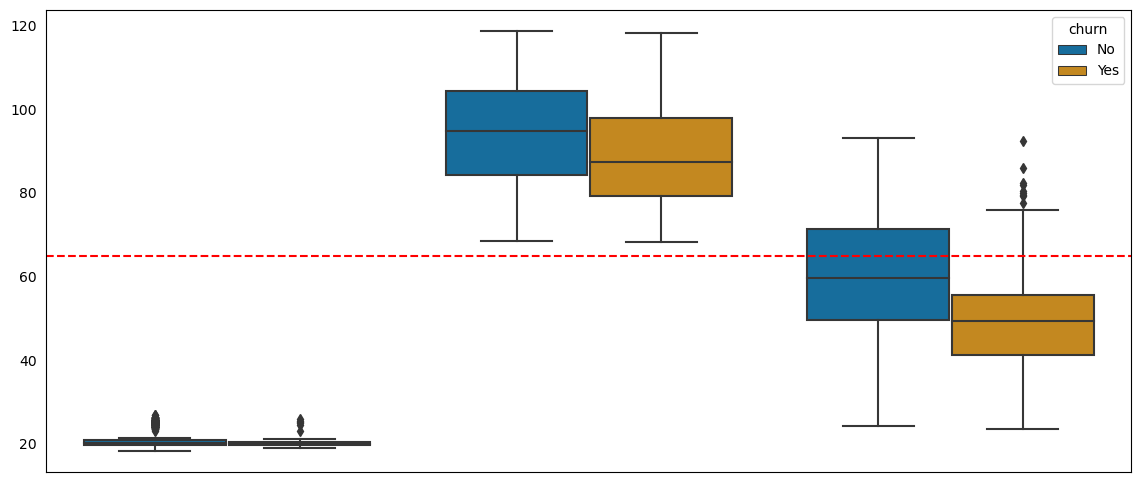

In [32]:
plt.figure(figsize=(14,6))
sns.set_palette('colorblind')
ax = sns.boxplot(data=train, x='internet_service_type', y='monthly_charges', hue='churn')
plt.axhline(y=train.monthly_charges.mean(), color='red', linestyle='dashed')
ax.set(xlabel=None, ylabel=None)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);
#plt.title('Fiber customers pay higher than average, but those that churn pay *less* than those that do not')
#plt.show()

* Is there a problem with certain services over time?
    * `churn` vs `tenure` and `internet_service_type`
    * Takeaways: Newer fiber customers at higher risk for churn

In [33]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

<Figure size 2000x600 with 0 Axes>

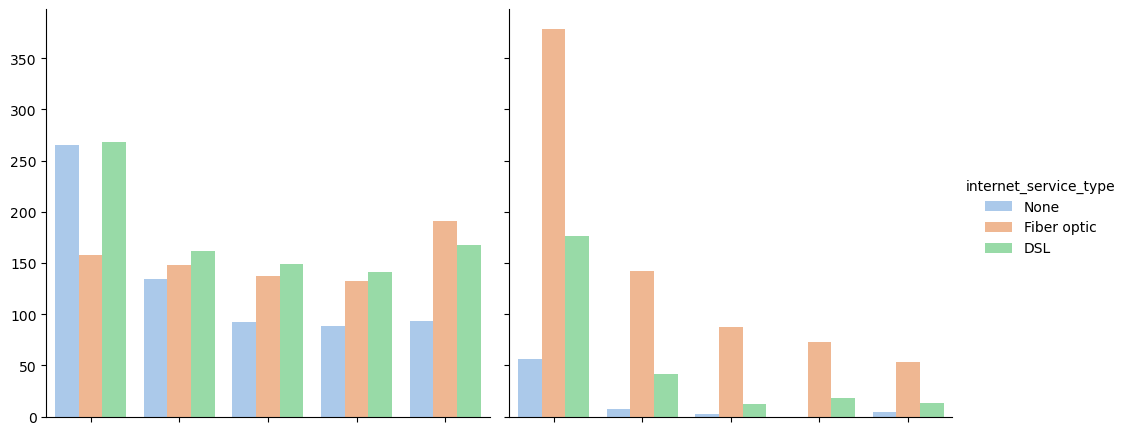

In [34]:
plt.figure(figsize=(20,6))
sns.set_palette('pastel')
palette = {'None'}
ax = sns.catplot(data=train, x='tenure_group', hue='internet_service_type', col='churn', kind='count');
ax.set(xlabel=None, ylabel=None)
ax.set_xticklabels([])
ax.set_titles('')


In [35]:
((fiber.churn_encoded == 1) & (fiber.tenure < 13)).mean()

0.20310825294748125

## Statistical Tests

> Do customers that have churned pay higher monthly prices? 
 
* ${H_0}$: Customers that have churned pay equal or less than those that have not churned.

* ${H_a}$: Customers that have churned pay more than those that have not churned.  

* Conclusion: I rejected the null hypothesis after statistical testing supported the conclusion that churned customers did in fact pay higher monthly prices

In [36]:
#set alpha
alpha = .05

churned = train[train.churn == 'Yes']
not_churned = train[train.churn =='No'] 

u, p = stats.mannwhitneyu(churned.monthly_charges, not_churned.monthly_charges)

print('\n----')
print(f'u = {u:.4f}')
print(f'p = {p:.4f}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


----
u = 2158765.0000
p = 0.0000
Reject null hypothesis


> Are longer tenured customers at less risk of churn?
* ${\alpha}$ = .05

* ${H_0}$: Customers that have churned show little to no difference in legnth of tenure.

* ${H_a}$: Customers that have curned show significant difference in length of tenure.

* Conclusion: I rejected the null hypothesis after statistical testing supported the conclusion that churned customers did in fact pay higher monthly prices

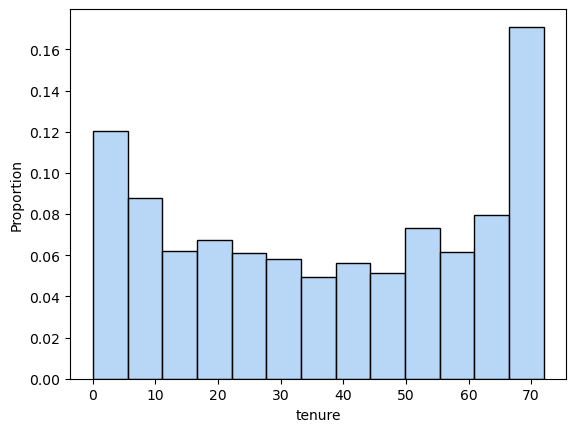

In [37]:
sns.histplot(data=not_churned, x='tenure', stat='proportion');

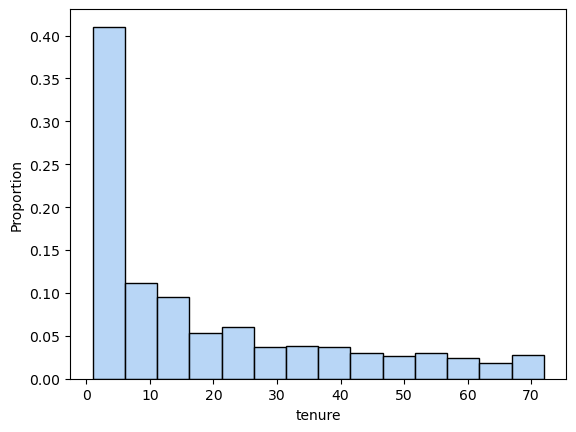

In [38]:
sns.histplot(data=churned, x='tenure', stat='proportion');

In [39]:
#set alpha
alpha = .05

churned = train[train.churn == 'Yes']
not_churned = train[train.churn =='No'] 

u, p = stats.mannwhitneyu(churned.tenure, not_churned.tenure)

print('\n----')
print(f'u = {u:.4f}')
print(f'p = {p:.4f}')
print('\n----')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


----
u = 922284.0000
p = 0.0000

----
Reject null hypothesis


## Exploration Takeaways
* Month-to-month customers seem more sensitive to higher prices than other groups
* Customers with less than 20 months more sensitive to higher prices
* Fiber customers pay higher than average, but those that churn pay *less* than those that do not
* 'Newer fiber customers at higher risk for churn